#  0.0 Setup

# 0.1 Imports

In [1]:

# Data Manipulation
import numpy               as np
import pandas              as pd

# Exploratory Data Analyses
import statistics          as st
import seaborn             as sns
import matplotlib.pyplot   as plt
import matplotlib.gridspec as gridspec
from scipy                 import stats     as ss
from scipy.stats           import pointbiserialr, chi2_contingency

# general utilities
import csv
import pickle
#from GeneralUtils         import GeneralUtils

#Configurations
import warnings
warnings.filterwarnings( 'ignore' )
from IPython.display       import Image
from IPython.core.display  import HTML

# Feature Selection
from boruta                    import BorutaPy
from sklearn.ensemble          import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

# Rescaling Features
from sklearn.preprocessing     import MinMaxScaler, LabelEncoder

# Machine Learning
from sklearn.model_selection import train_test_split
from imblearn.combine        import SMOTETomek
from sklearn.linear_model    import LogisticRegression, SGDClassifier
from catboost                import CatBoostClassifier
from lightgbm                import LGBMClassifier
from xgboost                 import XGBClassifier
from imblearn.ensemble       import BalancedRandomForestClassifier

# metrics
from random            import choices as rchoice
from sklearn.metrics   import accuracy_score, precision_score, recall_score
from sklearn.metrics   import roc_auc_score, f1_score, cohen_kappa_score, roc_curve
from sklearn.metrics   import precision_recall_curve, classification_report, brier_score_loss

# cross validation
from sklearn.model_selection import cross_val_score, StratifiedKFold, RepeatedStratifiedKFold 

# confusion matrix
from sklearn.metrics import plot_confusion_matrix

#fine tuning
from numpy                   import argmax
from skopt import BayesSearchCV

# 0.2 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container {width:100% !important;}</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings() 

Populating the interactive namespace from numpy and matplotlib


In [3]:

def descriptive_statistics (num_df):
    # Central Tendency - mean, median
    ct1 = pd.DataFrame(num_df.apply(np.mean)).T
    ct2 = pd.DataFrame(num_df.apply(np.median)).T

    # Dispersion - Std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame(num_df.apply(np.std)).T
    d2 = pd.DataFrame(num_df.apply(min)).T
    d3 = pd.DataFrame(num_df.apply(max)).T
    d4 = pd.DataFrame(num_df.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_df.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_df.apply(lambda x: x.kurtosis())).T

    # Concatenate
    m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    return m

In [4]:
def calcBMI(weight, height):
    #BMI = kg/m2
    bmi = np.round(weight / (height**2), 1)
    
    return bmi

def BMI(bmi):
    if bmi < 18.5:
        status = "Underweight"
    
    elif bmi >= 18.5 and bmi <= 24.9:
        status = "Healthy"
    
    elif bmi >= 25.0 and bmi <= 29.9:
        status = "Overweight"
        
    elif bmi >= 30.0:
        status = "Obese"
        
    return status

In [5]:
def cardio_table (dataframe, column):
    
    aux = dataframe[[column, 'cardio_disease']].groupby(column).sum().reset_index()
    
    aux['Total_Pacients'] = dataframe[[column, 'cardio_disease']].groupby(column).count().reset_index()['cardio_disease']
    aux.columns = [column, 'cardio_disease_1', 'Total_Patients']
    aux['Cardiac Patients Ratio (%)'] = np.round(((aux['cardio_disease_1'] / aux['Total_Patients'])*100), decimals=2)
    aux['Patients Percentage'] = np.round(((aux['Total_Patients'] / (aux['Total_Patients'].sum()))*100), decimals=2)
    aux.rename(columns={'cardio_disease_1': 'Cardiac Patients'})
    
    return aux

In [6]:
def iqr(data):
    # IQR weight
    Q1 = np.quantile(data, .25)
    Q3 = np.quantile(data, .75)
    interquartile = Q3 - Q1

    # calculate lower fence and using its value to eliminate outliers
    upper_fence = Q3 + (1.5 * interquartile)
    lower_fence = Q1 - (1.5 * interquartile)
        
    return print('For {}, the lower fence is {} and the upper is {}.'.format(data.name, lower_fence, upper_fence))

In [7]:
def cramer_v(x,y):

    cm = pd.crosstab( x, y).values
    n = cm.sum()
    r , k = cm.shape

    chi2 = ss.chi2_contingency ( cm )[0]
    chi2corr = max( 0, chi2 - ((k-1)*(r-1))/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
        
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1) ))

In [8]:
def feature_selection(model, X, y):
    model.fit(X, y)
        
    # Feature importance data frame
    feat_imp = pd.DataFrame({'feature': X.columns,
                             'feature_importance': model.feature_importances_}) \
                             .sort_values('feature_importance', ascending = False) \
                             .reset_index(drop = True)
        
    # Plot feature importance
    plt.figure(figsize = (12,6))
    sns.barplot(x = 'feature_importance', y = 'feature', data = feat_imp, orient = 'h', palette = 'winter_r')
    plt.title(type (model).__name__, size = 16)
    plt.yticks(size = 13)
    plt.xticks(size = 13)
    plt.xlabel('Feature Importance', size = 16, color = 'grey')
    plt.ylabel('Features', size = 16, color = 'grey')

In [9]:
def ml_performance(models, X_train, y_train, X_valid, y_valid, threshold):
    model_df = []     
    for model in models:
        print("Training " + type(model).__name__ + "...")
        model.fit(X_train, y_train)
        
        # prediction positive probabilities according to a threshold
        y_proba = model.predict_proba(X_valid)[:, 1]
        y_hat = (y_proba >= threshold).astype(int)
        
        # metrics
        f1 = f1_score(y_valid, y_hat)
        accuracy = accuracy_score(y_valid, y_hat)
        kappa = cohen_kappa_score(y_valid, y_hat)
        roc_auc = roc_auc_score(y_valid, y_hat)
        precision = precision_score(y_valid, y_hat)
        recall = recall_score(y_valid, y_hat)
        brier = brier_score_loss(y_valid, y_hat, pos_label=1)
        
        metrics = pd.DataFrame({'Model Name': type(model).__name__,'Accuracy': accuracy,'Precision': precision,
                                'Recall': recall,'F1-Score': f1,'ROC-AUC': roc_auc,'Kappa': kappa,
                                'Brier': brier}, index = [0]).sort_values('F1-Score', ascending = False)
        
        model_df.append(metrics)
        final_model = pd.concat(model_df)
    return final_model.sort_values('F1-Score', ascending = False).round(5)

In [10]:

def cross_validation(models, X, y, cv):
    cv_df = []
    for n in models:
        accuracy_cv = cross_val_score(n, X, y, cv = cv, scoring='accuracy', n_jobs=-1)
        accuracy = "{:.4f} +/- %{:.4f}".format(accuracy_cv.mean(), accuracy_cv.std())
        prec_cv = cross_val_score(n, X, y, cv = cv, scoring='precision', n_jobs=-1)
        prec = "{:.4f} +/- %{:.4f}".format(prec_cv.mean(), prec_cv.std())
        recall_cv = cross_val_score(n, X, y, cv = cv, scoring='recall', n_jobs=-1)
        recall = "{:.4f} +/- %{:.4f}".format(recall_cv.mean(), recall_cv.std())
        f1_score_cv = cross_val_score(n, X, y, cv = cv, scoring='f1', n_jobs=-1)
        f1_score = "{:.4f} +/- %{:.4f}".format(f1_score_cv.mean(), f1_score_cv.std())
        roc_auc_cv = cross_val_score(n, X, y, cv = cv, scoring='roc_auc', n_jobs=-1)
        roc_auc = "{:.4f} +/- %{:.4f}".format(roc_auc_cv.mean(), roc_auc_cv.std())
        
                
        A = pd.DataFrame( {'Model Name': type(n).__name__,
                           'Accuracy (Avg+Std)': accuracy,
                           'Precision (Avg+Std) ': prec,
                           'Recall (Avg+Std) ': recall,
                           'F1-Score (Avg+Std)': f1_score,
                           'ROC-AUC (Avg+Std)': roc_auc }, index = [0])
    
        cv_df.append(A)
        final_df = pd.concat(cv_df)

    return final_df

# 0.3  Loading Data

In [11]:
df_cardio_raw = pd.read_csv('../data/cardio_train.csv', low_memory= False, delimiter=';')

# 1.0. Descrição dos dados

In [12]:
df1 = df_cardio_raw.copy()

In [13]:
df1.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


##  1.1 Feature Description


**There are 3 types of input features**:

**Objective**: factual information;

**Examination**: results of medical examination;

**Subjective**: information given by the patient.

**Features**:
- **Age** | Objective Feature | age | int (days)

- **Height** | Objective Feature | height | int (cm) |

- **Weight** | Objective Feature | weight | float (kg) |

- **Gender** | Objective Feature | gender | categorical code |

- **Systolic** blood pressure | Examination Feature | ap_hi | int |

- **Diastolic** blood pressure | Examination Feature | ap_lo | int |

- **Cholesterol** | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |

- **Glucose** | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |

- **Smoking** | Subjective Feature | smoke | binary |

- **Alcohol intake** | Subjective Feature | alco | binary |

- **Physical activity** | Subjective Feature | active | binary |

- **Presence or absence of cardiovascular disease** | Target Variable | cardio | binary |

All of the dataset values were collected at the moment of medical examination.

## 1.2 Rename Columns

In [14]:
new_columns = {"ap_hi": "systolic_blood_pressure", "ap_lo": "diastolic_blood_pressure", "gluc": "glucose",
              "smoke": "smoking", "alco": "alcohol", "active": "physical_activity", "cardio": "cardio_disease"}

df1.rename(columns=new_columns, inplace=True)

df1.head()

,id,age,gender,height,weight,systolic_blood_pressure,diastolic_blood_pressure,cholesterol,glucose,smoking,alcohol,physical_activity,cardio_disease
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


## 1.3 Data Dimentions

In [15]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 70000
Number of cols: 13


## 1.4 Data Types

In [16]:
df1.dtypes

id                            int64
age                           int64
gender                        int64
height                        int64
weight                      float64
systolic_blood_pressure       int64
diastolic_blood_pressure      int64
cholesterol                   int64
glucose                       int64
smoking                       int64
alcohol                       int64
physical_activity             int64
cardio_disease                int64
dtype: object

## 1.5 Check NA

In [17]:
df1.isna().sum()

id                          0
age                         0
gender                      0
height                      0
weight                      0
systolic_blood_pressure     0
diastolic_blood_pressure    0
cholesterol                 0
glucose                     0
smoking                     0
alcohol                     0
physical_activity           0
cardio_disease              0
dtype: int64

## 1.6 Change Types

We're going to convert the age units from days to years so it becomes easier to interpret and check if there is any outlier. However, for the future calculations, we're going to keep the days column, because there's a chance that we may lose information by rounding the data.

In [18]:
# converting days to years
df1['age_years'] = ((df1['age'])/365).round(2)
df1.head()

,id,age,gender,height,weight,systolic_blood_pressure,diastolic_blood_pressure,cholesterol,glucose,smoking,alcohol,physical_activity,cardio_disease,age_years
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50.39
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55.42
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,51.66
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48.28
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,47.87


Gender can be estimated by height, as men are on average taller than women of the same age.

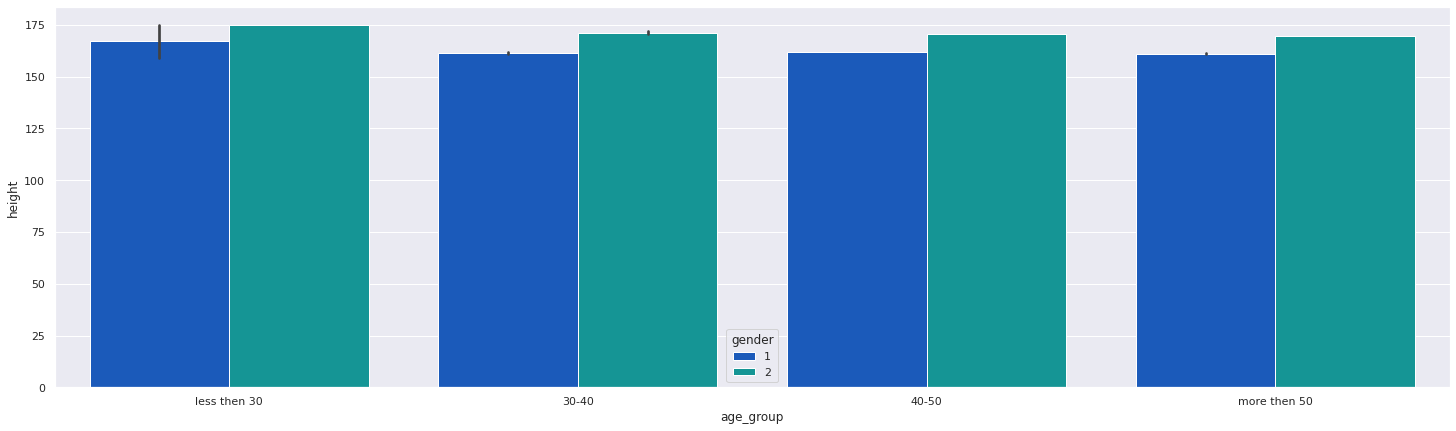

In [19]:
sns.set(rc={'figure.figsize':(25,7)})

df1['age_group'] = df1['age_years'].apply( lambda x: 'less then 30' if x <= 30 else 
                                         ( '30-40' if 30<x<= 40 else 
                                          ( '40-50' if 40<x<= 50 else 'more then 50' )))

sns.barplot( x = 'age_group', y = 'height', data = df1, hue = 'gender', palette = 'winter', order = ['less then 30', '30-40', '40-50', 'more then 50']);

In [20]:
df1['gender'] = df1['gender'].apply( lambda x: 'women' if x == 2 else 'men')


# changing the descriptions contained at Features Description for exploratory data analysis:
df1['cholesterol'] = df1['cholesterol'].apply( lambda x: 'normal' if x == 1 else 'above normal' if x == 2 else 'well above normal')
df1['glucose'] = df1['glucose'].apply( lambda x: 'normal' if x == 1 else 'above normal' if x == 2 else 'well above normal')

# transforming float in int number:
df1['weight'] = df1['weight'].astype(int)

In [21]:
df1.dtypes

id                            int64
age                           int64
gender                       object
height                        int64
weight                        int64
systolic_blood_pressure       int64
diastolic_blood_pressure      int64
cholesterol                  object
glucose                      object
smoking                       int64
alcohol                       int64
physical_activity             int64
cardio_disease                int64
age_years                   float64
age_group                    object
dtype: object

## 1.7 Descriptive Statistics

In [22]:
num_attributes = df1.select_dtypes(include = ['int64', 'int32', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'int32', 'float64'])

### 1.7.1 Numerical Attributes

In [23]:
descriptive_statistics(num_attributes)


,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,0.00,99999.00,99999.00,49972.419900,50001.50,28851.096242,-0.001278,-1.198374
1,age,10798.00,23713.00,12915.00,19468.865814,19703.00,2467.234044,-0.307055,-0.823447
2,height,55.00,250.00,195.00,164.359229,165.00,8.210068,-0.642187,7.943653
3,weight,10.00,200.00,190.00,74.204329,72.00,14.395850,1.012030,2.586746
4,systolic_blood_pressure,-150.00,16020.00,16170.00,128.817286,120.00,154.010319,85.296214,7580.074738
5,diastolic_blood_pressure,-70.00,11000.00,11070.00,96.630414,80.00,188.471184,32.114083,1425.914585
6,smoking,0.00,1.00,1.00,0.088129,0.00,0.283482,2.905867,6.444250
7,alcohol,0.00,1.00,1.00,0.053771,0.00,0.225566,3.956607,13.655125
8,physical_activity,0.00,1.00,1.00,0.803729,1.00,0.397176,-1.529473,0.339296
9,cardio_disease,0.00,1.00,1.00,0.499700,0.00,0.500000,0.001200,-2.000056


In [24]:
# Divide features in numerical, categorical and binary
num_attributes = df1[['id','age', 'height', 'weight', 'systolic_blood_pressure', 'diastolic_blood_pressure','age_years']]
bin_attributes = df1[['smoking', 'alcohol', 'physical_activity', 'cardio_disease']]
cat_attributes = df1.select_dtypes(exclude = ['int64', 'int32', 'float64'])

In the data we can see possible outliers:

Minimum height = 55.00, and minimum weight = 10.00, when age_years = 29.58;

Maximum blood pressure systolic_blood_pressure = 16170.00 and diastolic_blood_pressure = 11070.00.

Minimum blood pressure systolic_blood_pressure and diastolic_blood_pressure negatives.

### 1.7.2 Categorical Attributes

In [25]:
cat_attributes.apply( lambda x: x.unique().shape[0])

gender         2
cholesterol    3
glucose        3
age_group      4
dtype: int64

<AxesSubplot:xlabel='glucose', ylabel='count'>

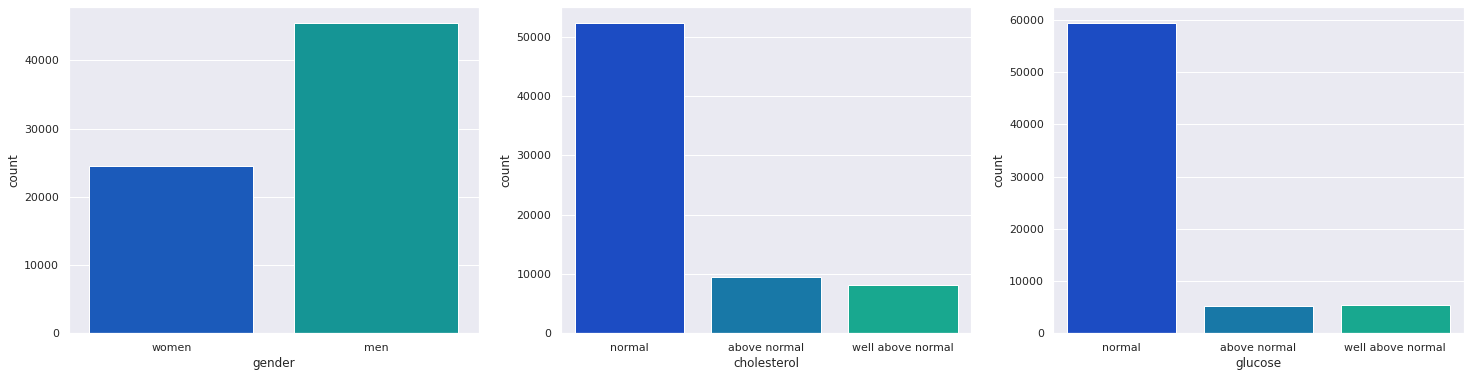

In [26]:
sns.set(rc={'figure.figsize':(25,6)})

plt.subplot(1,3,1)
sns.countplot(df1['gender'], palette = 'winter')

plt.subplot(1,3,2)
sns.countplot(df1['cholesterol'], palette = 'winter', order = ['normal', 'above normal', 'well above normal'])

plt.subplot(1,3,3)
sns.countplot(df1['glucose'], palette = 'winter')

## 1.8 Outliers 

### 1.8.1 Checking outliers

<AxesSubplot:xlabel='height'>

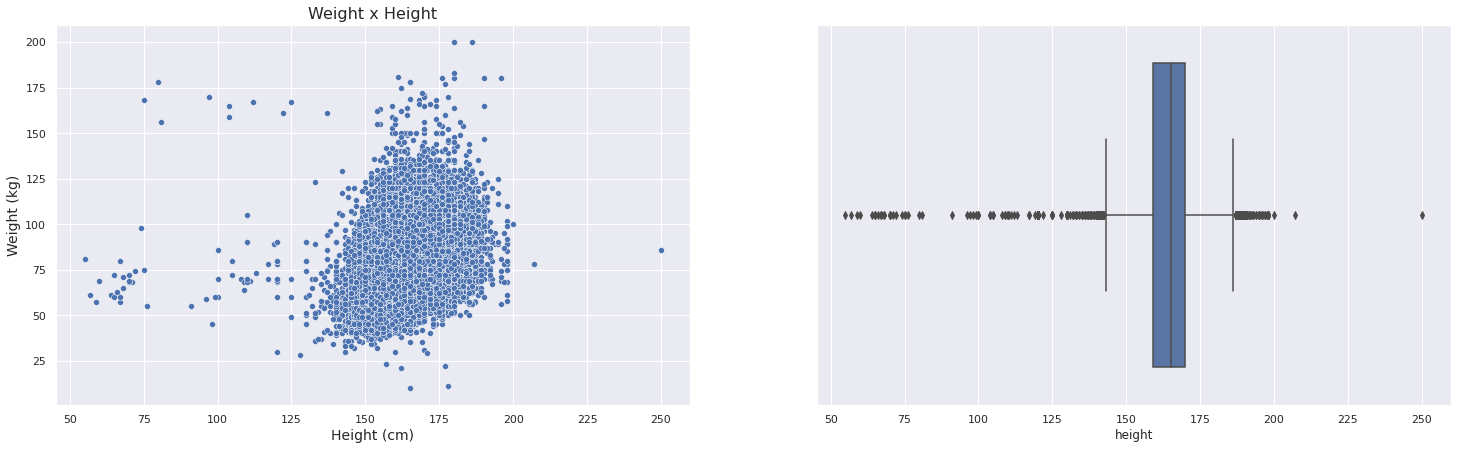

In [27]:
sns.set(rc={'figure.figsize':(25,7)})

plt.subplot(1,2,1)
sns.scatterplot(x="height", y="weight", data = df1, palette = 'winter')
plt.xlabel("Height (cm)", fontsize=14)
plt.ylabel("Weight (kg)", fontsize=14)
plt.title("Weight x Height", fontsize=16)

# Boxplot of height
plt.subplot(1,2,2)
sns.boxplot(df1['height'])



In this graph, we can see the presence of some outliers in addition to those we saw in the Numerical Attributes table. We will analyze the "height" and "weight" variables separately to define the outliers limits.



<AxesSubplot:xlabel='weight'>

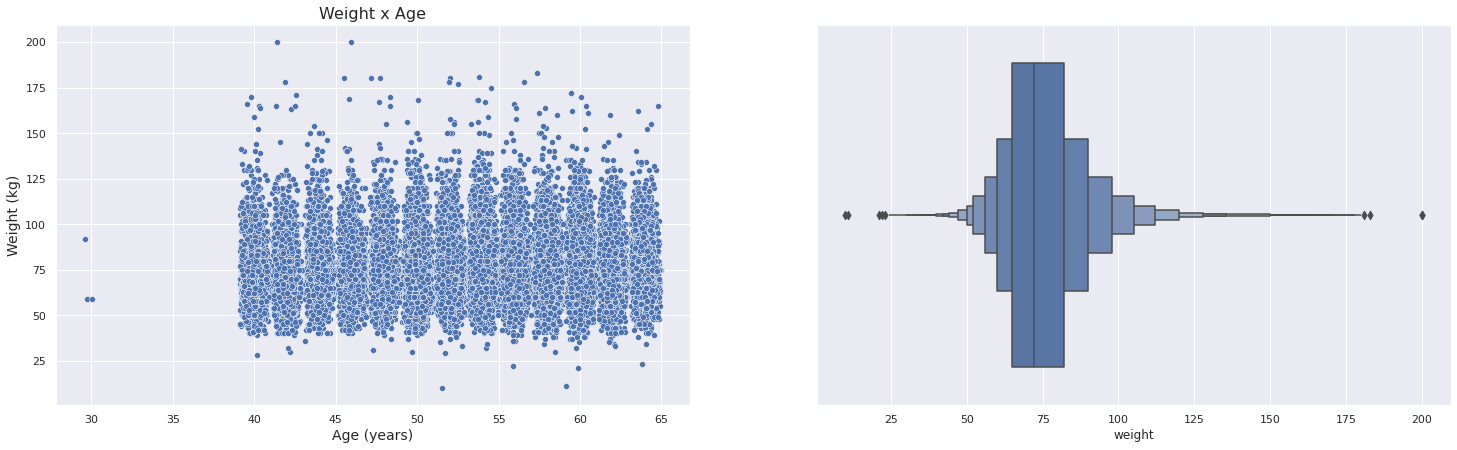

In [28]:
sns.set(rc={'figure.figsize':(25,7)})

plt.subplot(1,2,1)
sns.scatterplot(x='age_years', y='weight', data=df1, palette = 'winter')
plt.xlabel("Age (years)", fontsize=14)
plt.ylabel("Weight (kg)", fontsize=14)
plt.title("Weight x Age", fontsize=16)

# Boxplot of weight
plt.subplot(1,2,2)
sns.boxenplot(df1['weight'])

Ages lower than 35 years will be considered outliers.

Points in weight lower then 40 kg, will be considered outliers.

Text(0.5, 1.0, 'Height x Age')

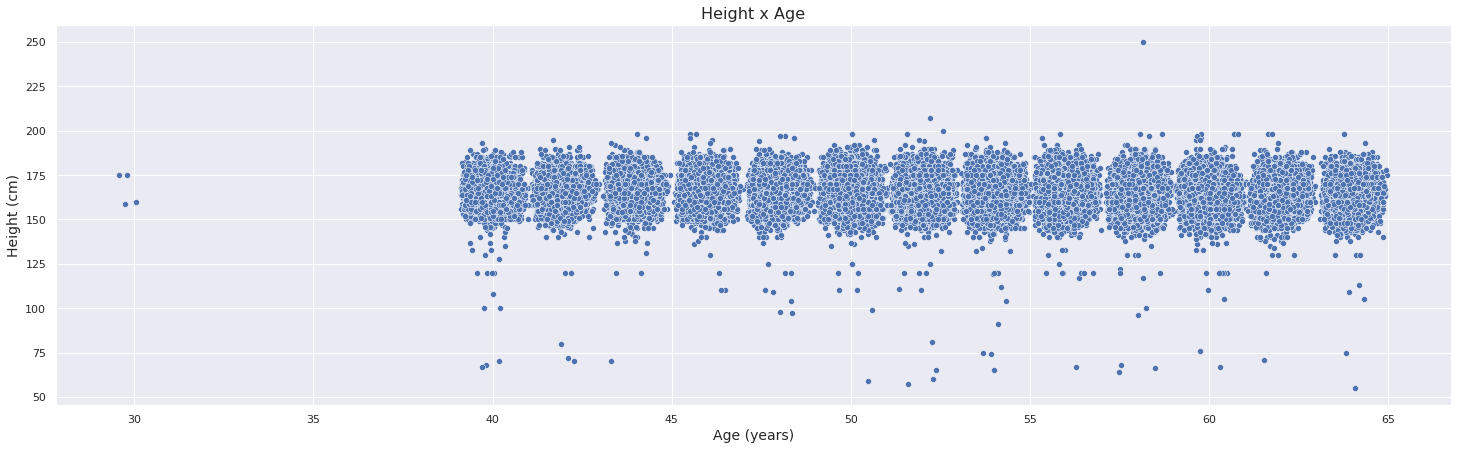

In [29]:
sns.set(rc={'figure.figsize':(25,7)})

sns.scatterplot(x='age_years', y='height', data=df1, palette = 'winter')
plt.xlabel("Age (years)", fontsize=14)
plt.ylabel("Height (cm)", fontsize=14)
plt.title("Height x Age", fontsize=16)

Points in height: x <= 110 cm or 210 cm <= x, will be considered outliers.

Text(0.5, 1.0, 'Diastolic x Systolic')

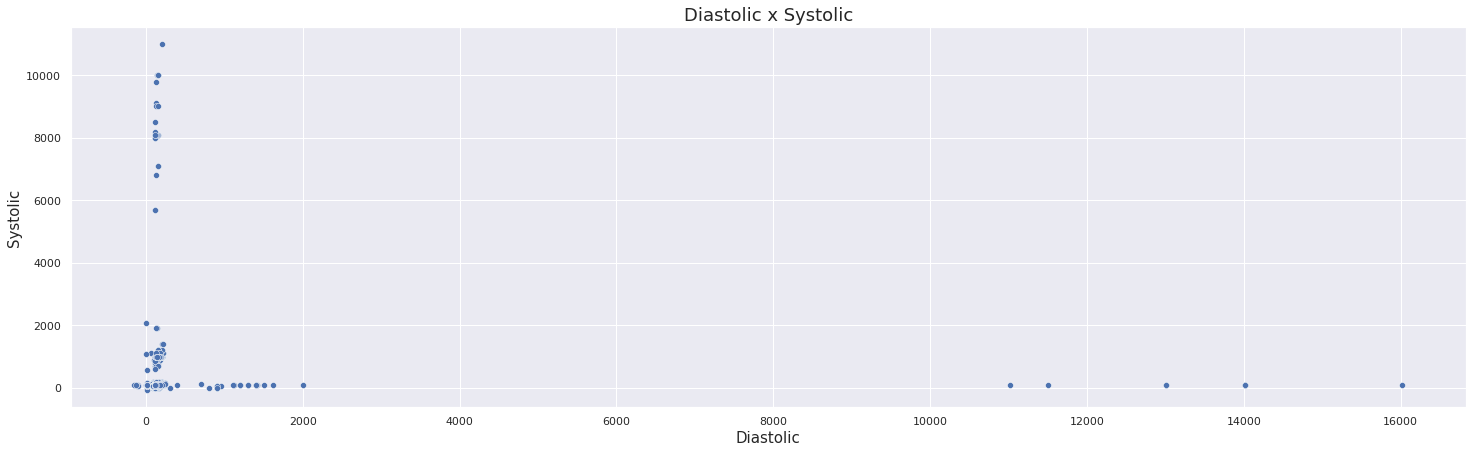

In [30]:

sns.set(rc={'figure.figsize':(25,7)})

sns.scatterplot(x='systolic_blood_pressure', y='diastolic_blood_pressure', data=df1)
plt.xlabel("Diastolic", fontsize=15)
plt.ylabel("Systolic", fontsize=15)
plt.title("Diastolic x Systolic", fontsize=18)

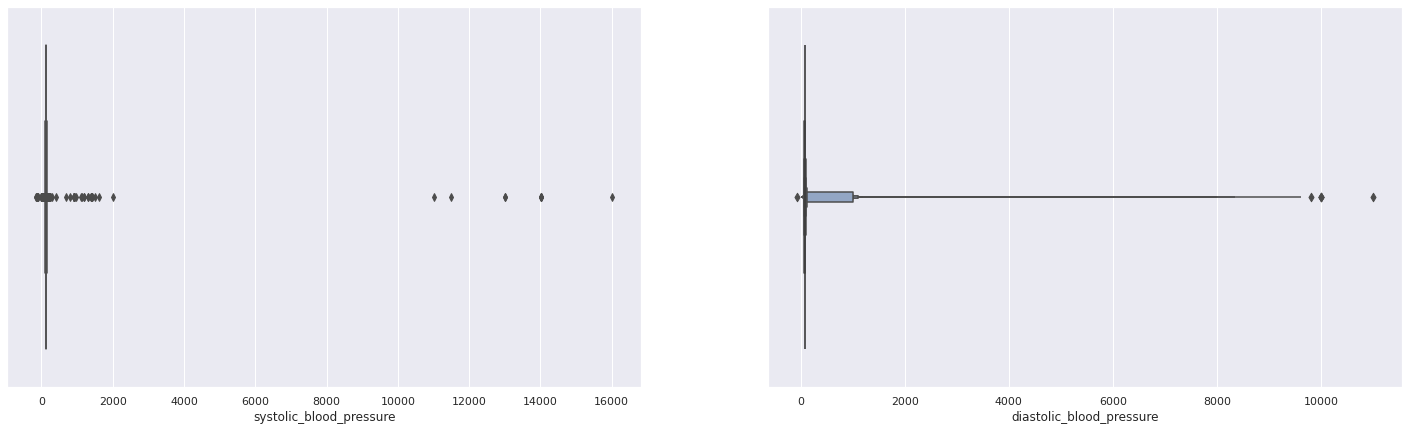

In [31]:
# Boxplot of ap_hi
plt.subplot(1,2,1)
sns.boxplot(df1['systolic_blood_pressure'])

# Boxplot of ap_lo
plt.subplot(1,2,2) 
sns.boxenplot(df1['diastolic_blood_pressure']);

Points up to 210 for Diastolic and Systolic blood pressure, will be considered outliers.


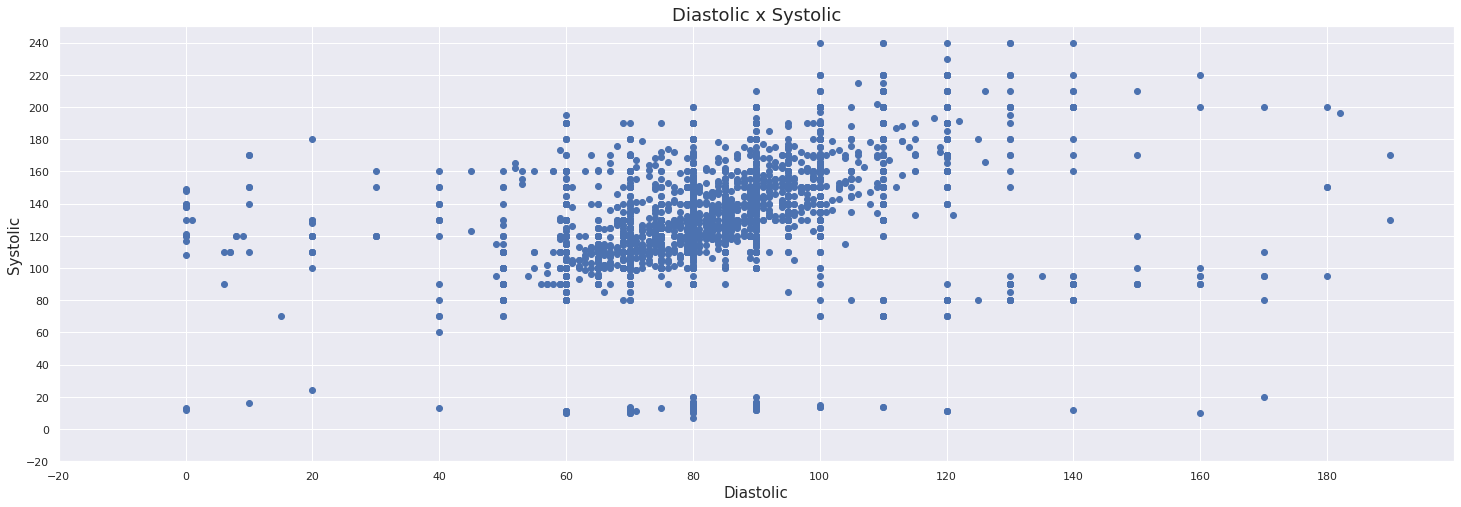

In [32]:
fig, ax = plt.subplots(figsize=(25,8))

plt.scatter(df1['diastolic_blood_pressure'],df1['systolic_blood_pressure'])
plt.xlabel("Diastolic", fontsize=15)
plt.ylabel("Systolic", fontsize=15)
plt.title("Diastolic x Systolic", fontsize=18)
start, end = ax.set_xlim([-20,200])
ax.xaxis.set_ticks(np.arange(start, end, 20))
start, end = ax.set_ylim([-20,250])
ax.yaxis.set_ticks(np.arange(start, end, 20))
ax.grid(True)

Points lower than 40 for Diastolic and 60 for Systolic blood pressure, will be considered outliers.

### 1.8.2 Removing outliers

In [33]:

# removing outliers: blood pressure
df_new = df1[~((df1['systolic_blood_pressure'] > 210) | (df1['diastolic_blood_pressure'] > 150) 
           | (df1['systolic_blood_pressure'] < 60) | (df1['diastolic_blood_pressure'] < 40))]

# removing outliers: height
df_new = df_new[~((df_new['height'] <= 110) | (df_new['height'] >= 210))]

# removing outliers: weight
df_new = df_new[~(df_new['weight'] <= 40)]

# removing outliers: age
df_new = df_new[~(df_new['age_years'] < 35)]

df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68587 entries, 0 to 69999
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        68587 non-null  int64  
 1   age                       68587 non-null  int64  
 2   gender                    68587 non-null  object 
 3   height                    68587 non-null  int64  
 4   weight                    68587 non-null  int64  
 5   systolic_blood_pressure   68587 non-null  int64  
 6   diastolic_blood_pressure  68587 non-null  int64  
 7   cholesterol               68587 non-null  object 
 8   glucose                   68587 non-null  object 
 9   smoking                   68587 non-null  int64  
 10  alcohol                   68587 non-null  int64  
 11  physical_activity         68587 non-null  int64  
 12  cardio_disease            68587 non-null  int64  
 13  age_years                 68587 non-null  float64
 14  age_gr

In [34]:
ratio_of_outliers_removed = 100 - (df_new.shape[0] / df1.shape[0]) * 100
print(f'Ratio of removed outliers: {round(ratio_of_outliers_removed, 2)}%')

Ratio of removed outliers: 2.02%


### 1.8.3 Exporting Data

In [35]:
df_new.to_csv('../data/clean_data.csv', index=False)

# 2.0. Feature Engineering

In [36]:
df2 = df_new.copy()

## 2.1 Mind Map Hypotheses

## 2.2 Hypotheses criation

### 2.2.1 Diseases Hypotheses

1. People with a previous heart disease should have more cardio disease.

2. People with a family history of heart disease should have more cardio disease.

3. People with autoimmune diseases should have more cardio disease.

4. People with hipertension should have more cardio disease.

5. People with diabetes should have more cardio disease.

6. People with psychological illnesses like anxiety and depression should have more cardio disease.

### 2.2.2 Rates Hypotheses

1. People with systolic blood pressure higher then 140 should have more cardio disease.

2. People with systolic blood pressure lower then 90 should have more cardio disease.

3. People with diastolic blood pressure higher then 90 should have more cardio disease.

4. People with diastolic blood pressure lower then 60 should have more cardio disease.

5. People with triglycerides higher then 200mg/dL should have more cardio disease.

6. People with higher cholesterol should have more cardio disease.

7. People with glucose (fasting) higher then 125mg/dL should have more cardio disease.

### 2.2.3 Physical Characteristics Hypotheses


1. Men should have more cardio disease then women.

2. Obese people should have more cardio disease.

3. Height should not interfere with the likelihood of cardio disease.

4. Elderly people should have more cardio disease.

### 2.2.4 Physical Condition Hypotheses


1. People who practice physical activities should have less cardio disease.

2. People who drink should have more cardio disease.

3. People who smoke should have more cardio disease.

4. People who eat healthily should have less cardio disease.

## 2.3 Hypotheses final list


1. People with hipertension should have more cardio disease.

2. People with diabetes should have more cardio disease.

3. People with systolic blood pressure higher then 140 should have more cardio disease.

4. People with systolic blood pressure lower then 90 should have more cardio disease.

5. People with diastolic blood pressure higher then 90 should have more cardio disease.

6. People with diastolic blood pressure lower then 60 should have more cardio disease.

7. People with higher cholesterol should have more cardio disease.

8. Men should have more cardio disease then women.

9. Obese people should have more cardio disease.

10. Height should not interfere with the likelihood of cardio disease.

11. Elderly people should have more cardio disease.

12. People who practice physical activities should have less cardio disease.

13. People who smoke should have more cardio disease.

## 2.4 Hypotheses for future Analysis

1. People with a previous heart disease should have more cardio disease.

2. People with a family history of heart disease should have more cardio disease.

3. People with autoimmune diseases should have more cardio disease.

4. People with psychological illnesses like anxiety and depression should have more cardio disease.

5. People with triglycerides higher then 200mg/dL should have more cardio disease.

6. People with glucose (fasting) higher then 125mg/dL should have more cardio disease.

7. People who drink should have more cardio disease.

8. People who eat healthily should have less cardio disease.

## 2.5 Feature Engeneering

In [37]:
df2["BMI"] = df2[["height", "weight"]].apply(lambda x: calcBMI(x["weight"], x["height"]/100), axis=1)
df2["weight_status"] = df2["BMI"].apply(BMI)

In [38]:
df2['blood_pressure_stage'] = df2.apply( lambda x: 'hypertensive crisis' if (x['systolic_blood_pressure'] > 180) | (x['diastolic_blood_pressure'] > 120) 
                                        else 'high (stage 2)' if ((x['systolic_blood_pressure'] >= 140) & (x['systolic_blood_pressure'] <= 180)) | 
                                        ((x['diastolic_blood_pressure'] >= 90) & (x['diastolic_blood_pressure'] <= 120))
                                        else 'high (stage 1)' if ((x['systolic_blood_pressure'] >= 130) & (x['systolic_blood_pressure'] <= 139)) | 
                                        ((x['diastolic_blood_pressure'] >= 80) & (x['diastolic_blood_pressure'] <= 89))
                                        else 'elevated' if ((x['systolic_blood_pressure'] >= 120) & (x['systolic_blood_pressure'] <= 129)) & 
                                        (x['diastolic_blood_pressure'] < 80)
                                        else 'normal' if ((x['systolic_blood_pressure'] > 90) & (x['systolic_blood_pressure'] < 120)) & 
                                        ((x['diastolic_blood_pressure'] > 60) & (x['diastolic_blood_pressure'] < 80))
                                        else 'low' , axis = 1)

In [39]:
df2.head()

,id,age,gender,height,weight,systolic_blood_pressure,diastolic_blood_pressure,cholesterol,glucose,smoking,alcohol,physical_activity,cardio_disease,age_years,age_group,BMI,weight_status,blood_pressure_stage
0,0,18393,women,168,62,110,80,normal,normal,0,0,1,0,50.39,more then 50,22.0,Healthy,high (stage 1)
1,1,20228,men,156,85,140,90,well above normal,normal,0,0,1,1,55.42,more then 50,34.9,Obese,high (stage 2)
2,2,18857,men,165,64,130,70,well above normal,normal,0,0,0,1,51.66,more then 50,23.5,Healthy,high (stage 1)
3,3,17623,women,169,82,150,100,normal,normal,0,0,1,1,48.28,40-50,28.7,Overweight,high (stage 2)
4,4,17474,men,156,56,100,60,normal,normal,0,0,0,0,47.87,40-50,23.0,Healthy,low


# 3.0. Filtragem de Variáveis

In [40]:
df3 = df2.copy()

## 3.1  Line Filtering

<AxesSubplot:xlabel='BMI', ylabel='Density'>

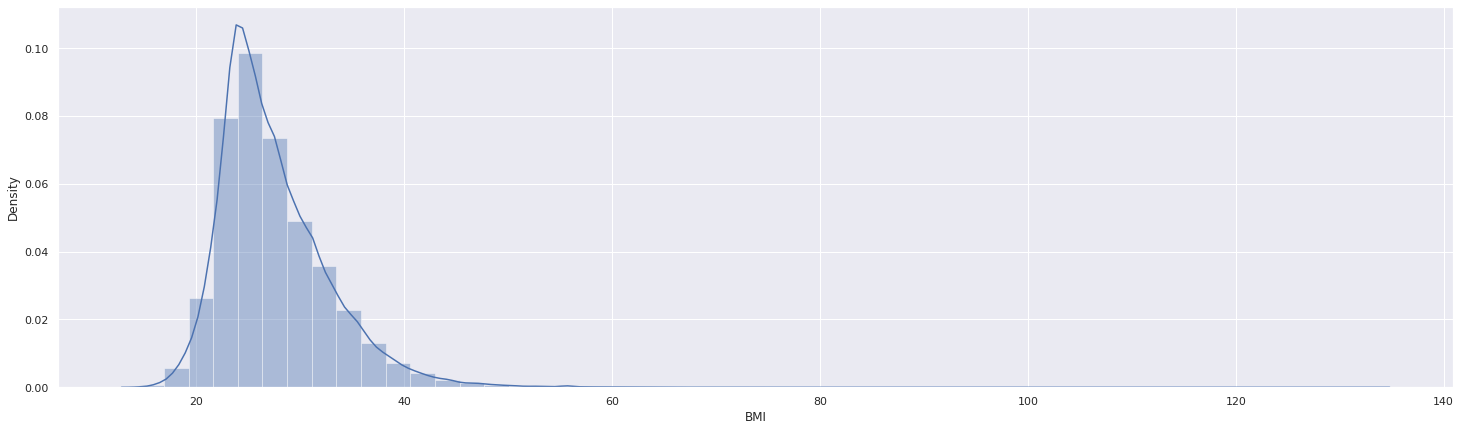

In [41]:
sns.set(rc={'figure.figsize':(25,7)})
sns.distplot(df3['BMI'])

In [42]:
# Removing outliers: BMI
df3 = df3[(df3['BMI'] < 60)]

<AxesSubplot:xlabel='BMI', ylabel='Density'>

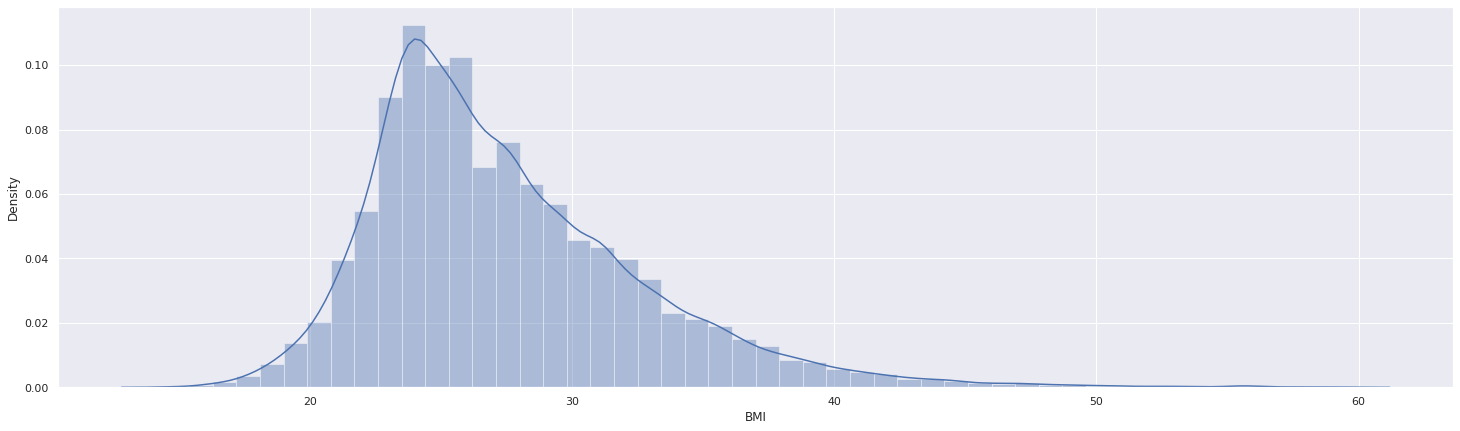

In [43]:
sns.set(rc={'figure.figsize':(25,7)})
sns.distplot(df3['BMI'])

## 3.2 Columns Selection

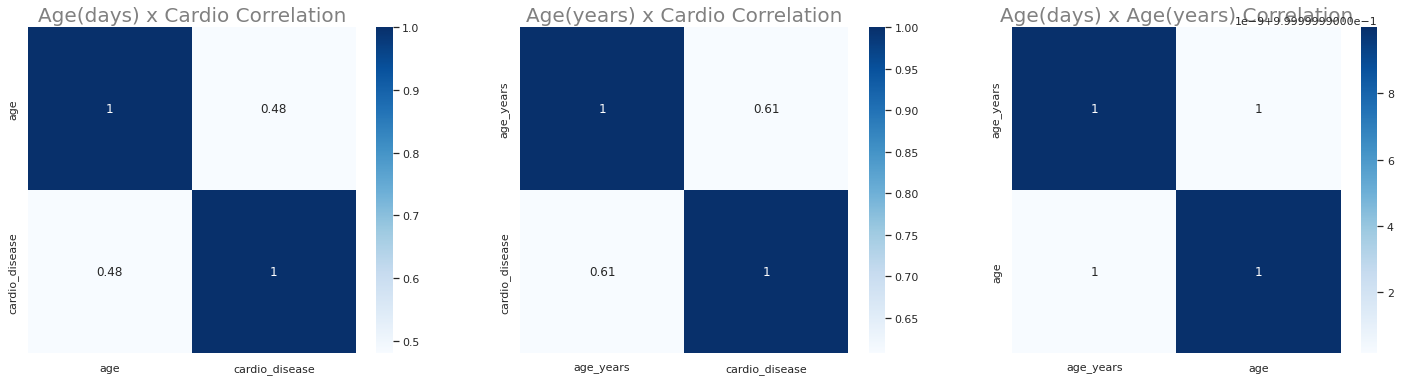

In [44]:

fig = plt.figure(figsize = (25,6))

plt.subplot (1,3,1)
aux1 = df3[['age', 'cardio_disease']].groupby ('age').mean().reset_index()
sns.heatmap(aux1.corr(method= 'pearson'), annot = True, annot_kws={"fontsize":12}, cmap="Blues");
plt.title("Age(days) x Cardio Correlation", size=20, color='gray');

plt.subplot (1,3,2)
aux2 = df3[['age_years', 'cardio_disease']].groupby ('age_years').mean().reset_index()
sns.heatmap(aux2.corr(method= 'pearson'), annot = True, annot_kws={"fontsize":12}, cmap="Blues");
plt.title("Age(years) x Cardio Correlation", size=20, color='gray');

plt.subplot (1,3,3)
aux3 = df3[['age_years', 'age']].groupby ('age_years').mean().reset_index()
sns.heatmap(aux3.corr(method= 'pearson'), annot = True, annot_kws={"fontsize":12}, cmap="Blues");
plt.title("Age(days) x Age(years) Correlation", size=20, color='gray');

In [45]:
cols_drop = ['age']
df3 = df3.drop(cols_drop, axis = 1)

# 4.0. Exploratory Data Analysis

In [46]:
df4 = df3.copy()

## 4.1 Univariate Analysis

## 4.1.1 Response Variable

<AxesSubplot:xlabel='cardio_disease', ylabel='Density'>

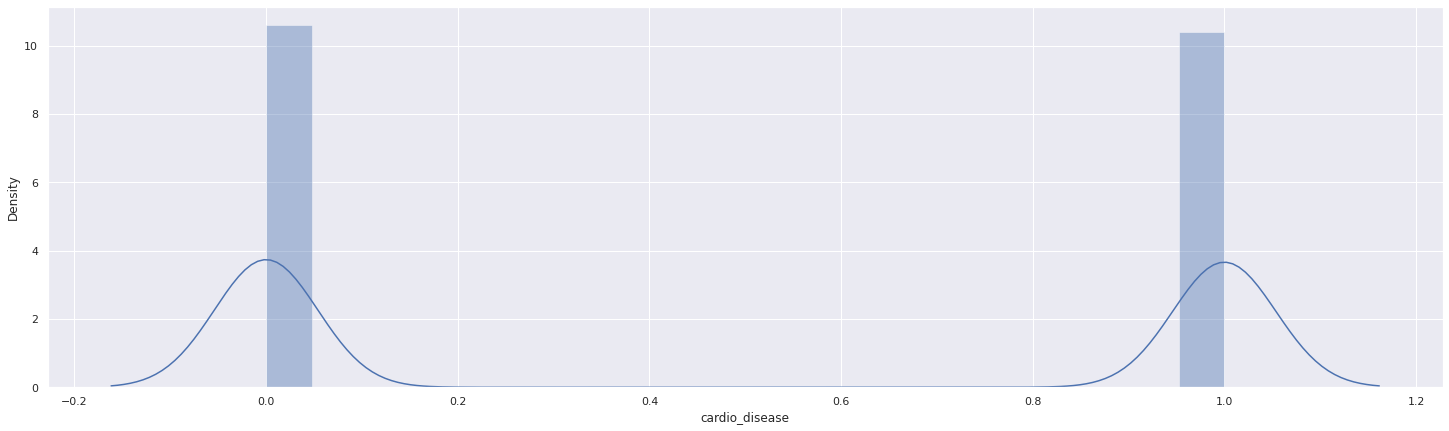

In [47]:
sns.set(rc={'figure.figsize':(25,7)})
sns.distplot(df4['cardio_disease'])

### 4.1.2 Numerical Variable

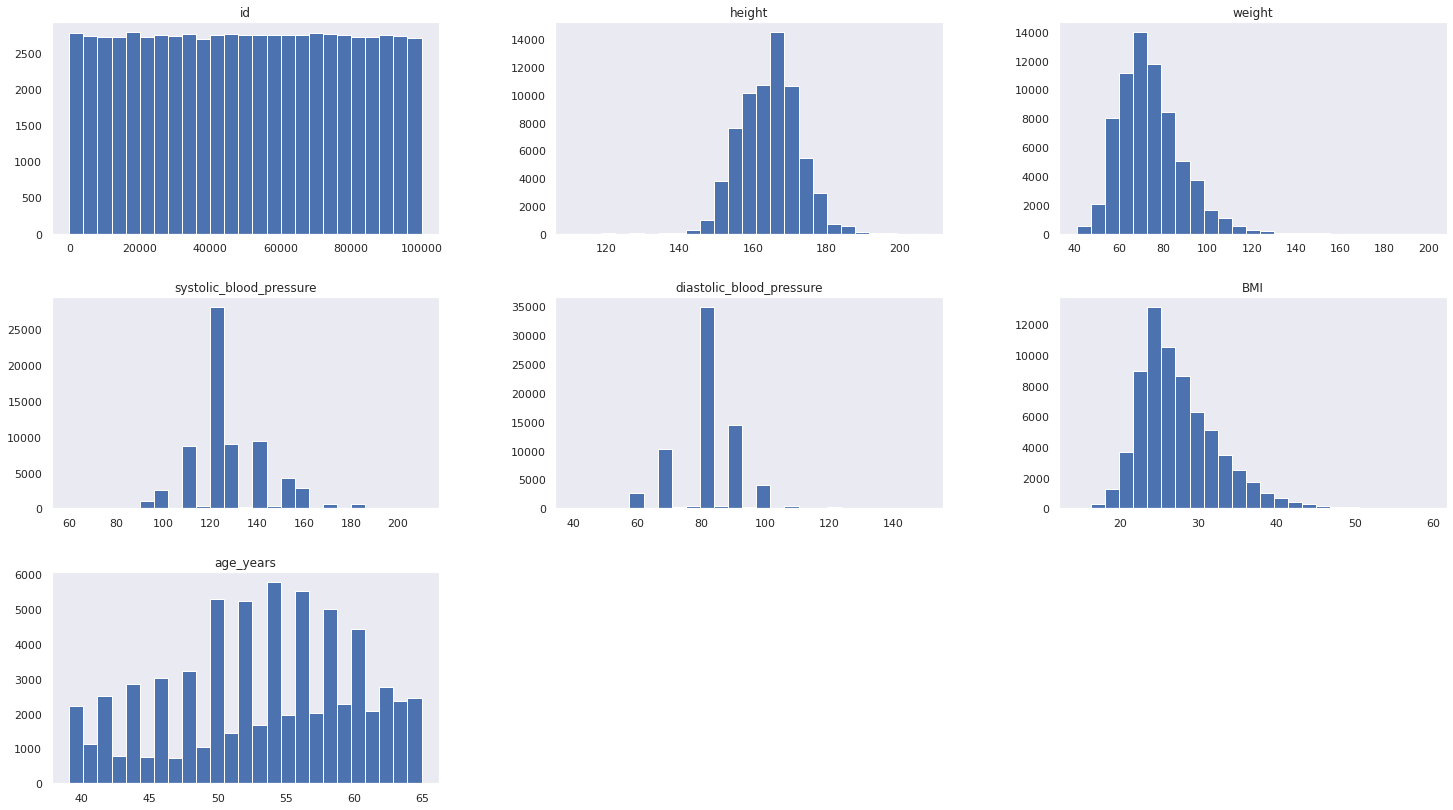

In [48]:
num_attributes = df4[['id', 'height', 'weight', 'systolic_blood_pressure', 'diastolic_blood_pressure', 'BMI','age_years']]
bin_attributes = df4[['smoking', 'alcohol', 'physical_activity', 'cardio_disease']]
cat_attributes = df4.select_dtypes(exclude = ['int64', 'int32', 'float64'])

fig = plt.figure(figsize = (25,14))
num_attributes.hist(bins = 25, ax = fig.gca(), grid = False);

In [49]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - Std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,0.00,99999.00,99999.00,49967.242613,50005.50,28849.034461,-0.000978,-1.198390
1,height,111.00,207.00,96.00,164.431711,165.00,7.899073,0.028388,0.635794
2,weight,41.00,200.00,159.00,74.128964,72.00,14.158155,0.960214,2.043286
3,systolic_blood_pressure,60.00,210.00,150.00,126.586258,120.00,16.611417,0.843994,1.445763
4,diastolic_blood_pressure,40.00,150.00,110.00,81.350004,80.00,9.520244,0.421541,2.129185
5,BMI,14.50,59.50,45.00,27.456098,26.30,5.191434,1.192822,2.372411
6,age_years,39.11,64.97,25.86,53.327742,53.97,6.757883,-0.303782,-0.829932


### 4.1.3 Categorical Variable

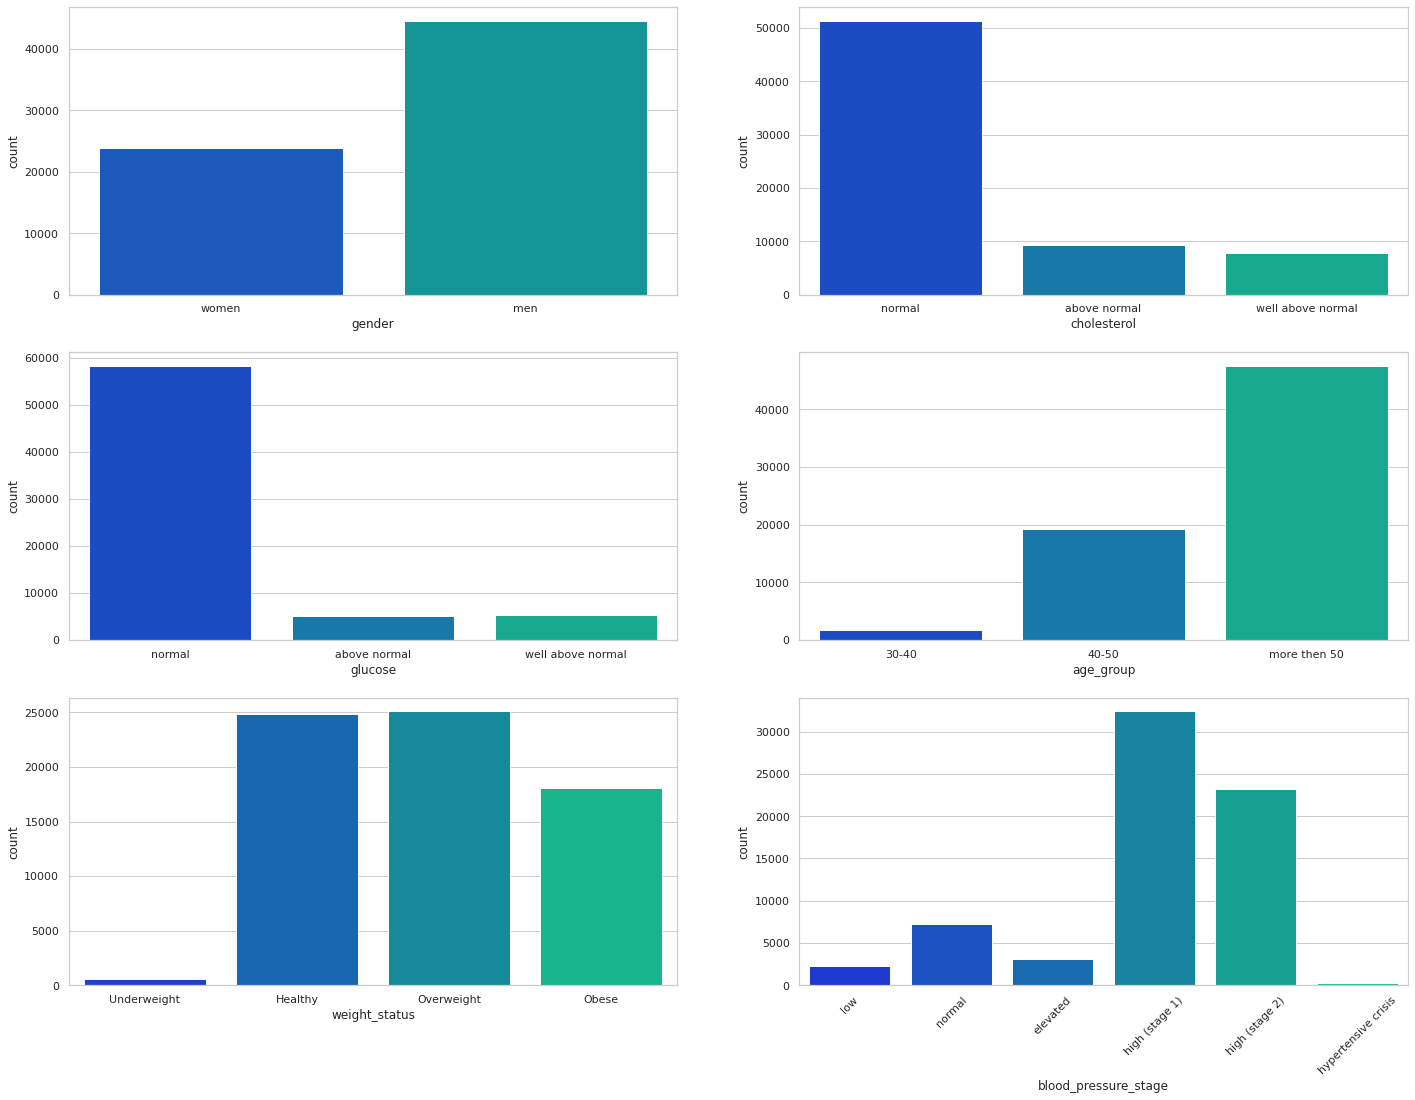

In [50]:

fig = plt.figure(figsize = (24,18))
sns.set_style("whitegrid")
sns.color_palette("winter")

# gender
plt.subplot (3,2,1)
sns.countplot(df4['gender'], palette = 'winter')

# cholesterol
plt.subplot (3,2,2)
sns.countplot(df4['cholesterol'], palette = 'winter', order = ['normal', 'above normal', 'well above normal'])

# glucose
plt.subplot (3,2,3)
sns.countplot(df4['glucose'], palette = 'winter')

# age_group
plt.subplot (3,2,4)
sns.countplot(df4['age_group'], palette = 'winter', order = ['30-40', '40-50', 'more then 50'])

# weight_status
plt.subplot (3,2,5)
sns.countplot(df4['weight_status'], palette = 'winter', order = ['Underweight', 'Healthy', 'Overweight', 'Obese'])

# blood_pressure_stage
plt.subplot (3,2,6)
sns.countplot(df4['blood_pressure_stage'], palette = 'winter', order=["low", "normal", 'elevated', 'high (stage 1)', 'high (stage 2)', 'hypertensive crisis'])
plt.xticks(rotation = 45);

## 4.2 Bivariate Analysis

**H1: People with hipertension should have more cardio disease.**

- **True.**People with hipertension HAVE MORE cardio disease.

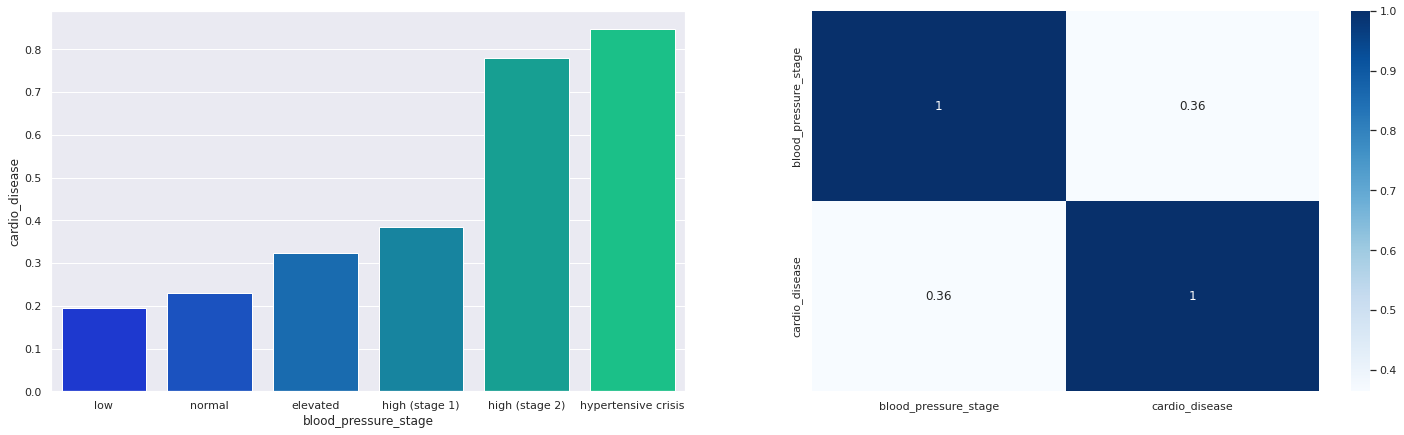

In [51]:
sns.set(rc={'figure.figsize':(25,7)})
plt.subplot (1,2,1)
aux1 = df4[['blood_pressure_stage', 'cardio_disease']].groupby('blood_pressure_stage').mean().reset_index()
sns.barplot (x = 'blood_pressure_stage', y = 'cardio_disease', data = aux1, palette = 'winter', order=["low", "normal", 'elevated', 'high (stage 1)', 'high (stage 2)', 'hypertensive crisis']);

aux2 = df4[['blood_pressure_stage', 'cardio_disease']]
aux2['blood_pressure_stage'] = aux2['blood_pressure_stage'].apply( lambda x: 1 if x == 'low' else 2 if x == 'normal' else 3 if x == 'elevated' else 4 if x == 'high (stage 1)' else 5 if x == 'high (stage 2)' else 6 )
plt.subplot (1,2,2)
sns.heatmap(aux2.corr(method= 'pearson'), annot = True, cmap="Blues");

In [52]:
cardio_table(df4,'blood_pressure_stage')

,blood_pressure_stage,cardio_disease_1,Total_Patients,Cardiac Patients Ratio (%),Patients Percentage
0,elevated,1004,3105,32.33,4.53
1,high (stage 1),12471,32406,38.48,47.27
2,high (stage 2),18100,23251,77.85,33.91
3,hypertensive crisis,256,302,84.77,0.44
4,low,446,2297,19.42,3.35
5,normal,1657,7201,23.01,10.50


**H2: People with diabetes should have more cardio disease.**
- **True.** People with diabetes have more cardio disease.    

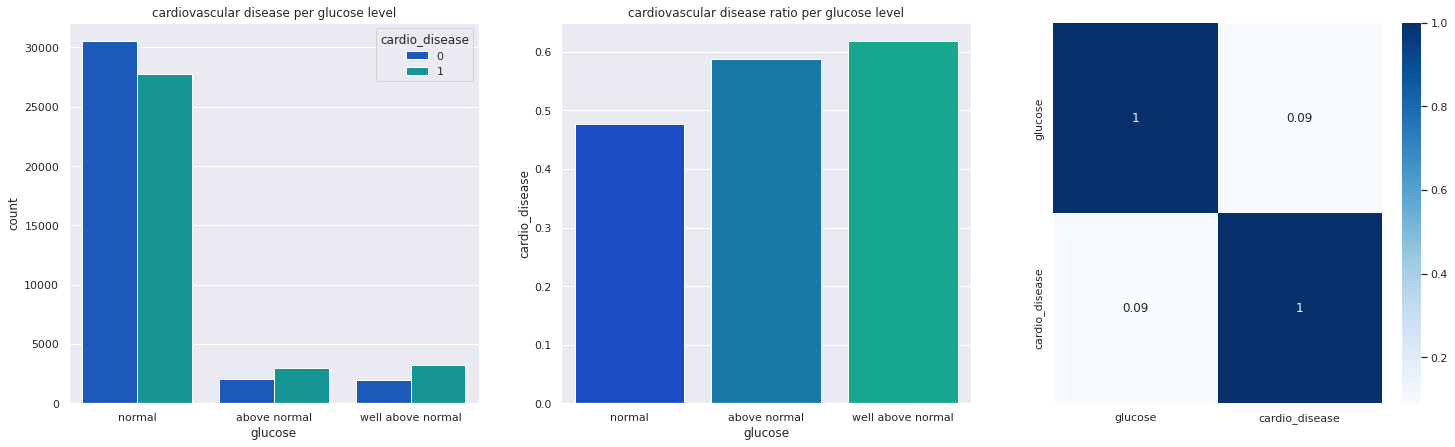

In [53]:
sns.set(rc={'figure.figsize':(25,7)})
aux1 = df4[['glucose', 'cardio_disease']].groupby('glucose').mean().reset_index()

plt.subplot(1, 3, 1)
sns.countplot(x='glucose', hue='cardio_disease', data=df4, palette = 'winter').set_title('cardiovascular disease per glucose level');

plt.subplot(1, 3, 2)
sns.barplot (x = 'glucose', y = 'cardio_disease', data = aux1,palette = 'winter', order = ['normal', 'above normal', 'well above normal']).set_title('cardiovascular disease ratio per glucose level');

aux2 = df4[['glucose', 'cardio_disease']]
aux2['glucose'] = aux2['glucose'].apply( lambda x: 1 if x == 'normal' else 2 if x == 'above normal' else 3)
plt.subplot (1,3,3)
sns.heatmap(aux2.corr(method= 'pearson'), annot = True, cmap="Blues");

In [54]:
cardio_table(df4,'glucose')

,glucose,cardio_disease_1,Total_Patients,Cardiac Patients Ratio (%),Patients Percentage
0,above normal,2975,5058,58.82,7.38
1,normal,27732,58286,47.58,85.01
2,well above normal,3227,5218,61.84,7.61


**H3: People with systilic blood pressure higher then 140 shoud have more cardio disease.**
- **True.** People with systyolic blodd pressure higher then 140 have more cardio disease.    

<AxesSubplot:>

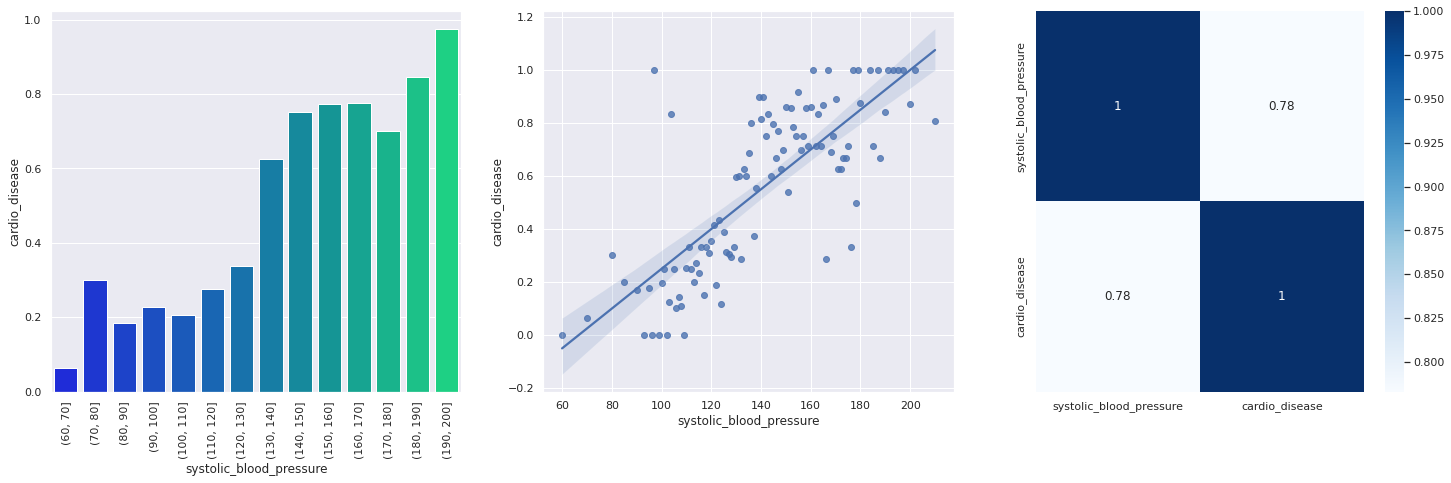

In [55]:
sns.set(rc={'figure.figsize':(25,7)})
aux1 = df4[['systolic_blood_pressure', 'cardio_disease']].groupby('systolic_blood_pressure').mean().reset_index()

plt.subplot (1,3,1)
bins = list(np.arange(60, 210, 10))
aux1['systolic_blood_pressure'] = pd.cut (aux1['systolic_blood_pressure'], bins = bins)
aux2 = aux1[['systolic_blood_pressure', 'cardio_disease']].groupby('systolic_blood_pressure').mean().reset_index()
sns.barplot (x = 'systolic_blood_pressure', y = 'cardio_disease', data = aux2, palette = 'winter')
plt.xticks(rotation = 90);

plt.subplot (1,3,2)
aux3 = df4[['systolic_blood_pressure', 'cardio_disease']].groupby('systolic_blood_pressure').mean().reset_index()
sns.regplot(x = 'systolic_blood_pressure', y = 'cardio_disease', data = aux3);

plt.subplot (1,3,3)
sns.heatmap(aux3.corr(method= 'pearson'), annot = True, cmap="Blues")

**H4: People with systolic blood pressure lower the 90 should have more cardio disease.**
- **False.** People with systolic blood pressure lower then 90 have less cardio disease.

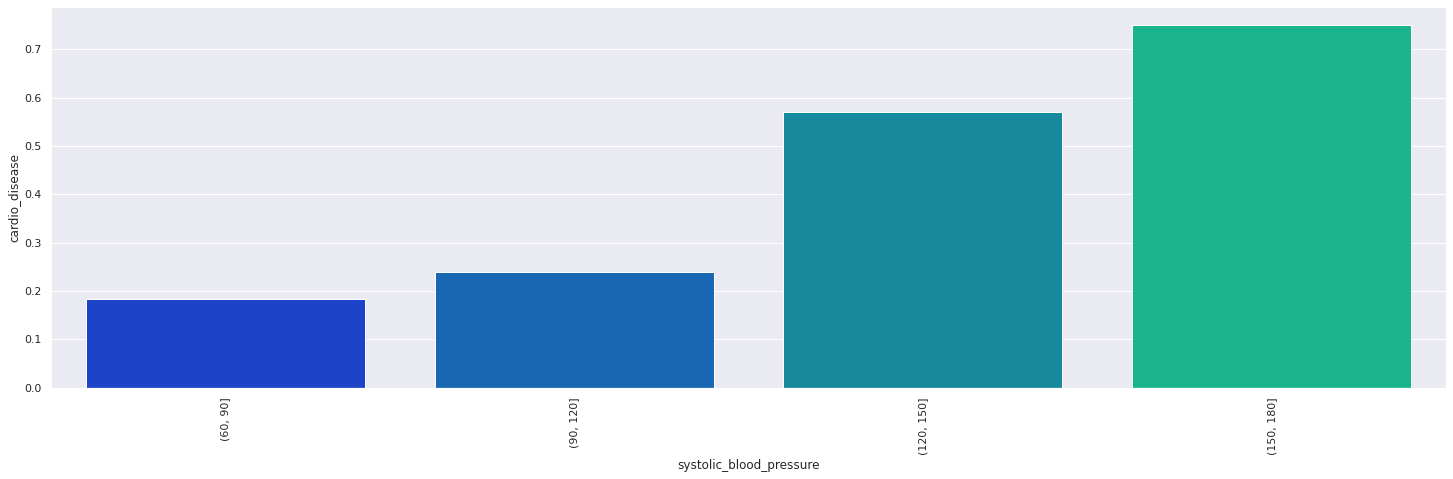

In [56]:
sns.set(rc={'figure.figsize':(25,7)})
aux1 = df4[['systolic_blood_pressure', 'cardio_disease']].groupby('systolic_blood_pressure').mean().reset_index()

bins = list(np.arange(60, 210, 30))
aux1['systolic_blood_pressure'] = pd.cut (aux1['systolic_blood_pressure'], bins = bins)
aux2 = aux1[['systolic_blood_pressure', 'cardio_disease']].groupby('systolic_blood_pressure').mean().reset_index()
sns.barplot (x = 'systolic_blood_pressure', y = 'cardio_disease', data = aux2, palette = 'winter')
plt.xticks(rotation = 90);

**H5: People with diastolic blood pressure higher the 90 shoud have more cardio disease.**
- **True.** People with diastolic blood pressure higher then 90 have more cardio disease.

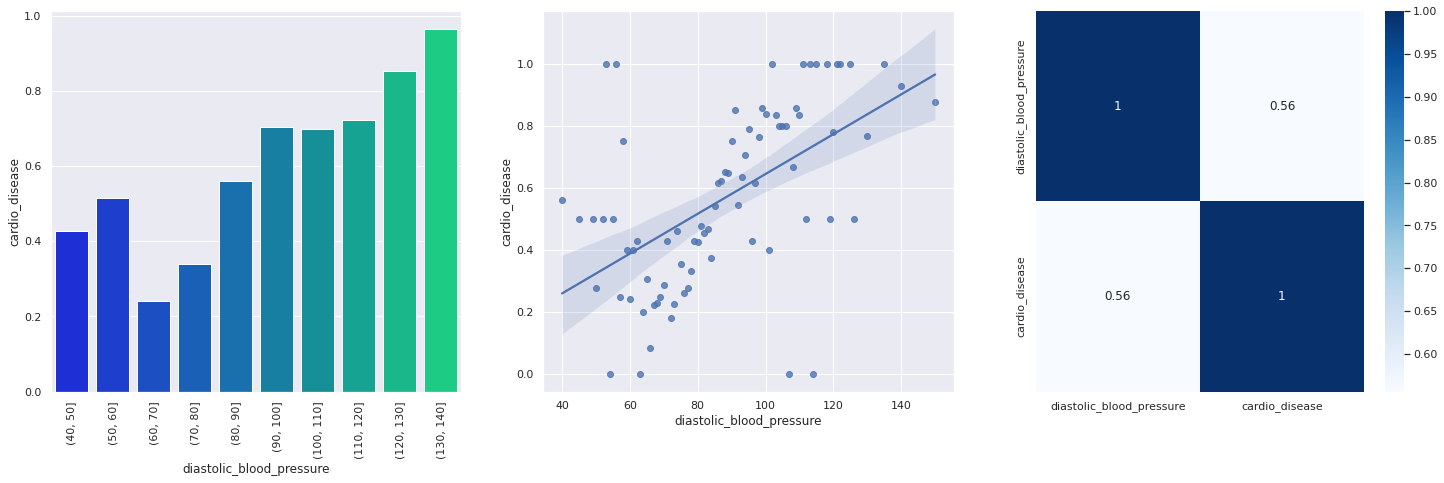

In [57]:
sns.set(rc={'figure.figsize':(25,7)})
aux1 = df4[['diastolic_blood_pressure', 'cardio_disease']].groupby('diastolic_blood_pressure').mean().reset_index()

plt.subplot (1,3,1)
bins = list(np.arange(40, 150, 10))
aux1['diastolic_blood_pressure'] = pd.cut (aux1['diastolic_blood_pressure'], bins = bins)
aux2 = aux1[['diastolic_blood_pressure', 'cardio_disease']].groupby('diastolic_blood_pressure').mean().reset_index()
sns.barplot (x = 'diastolic_blood_pressure', y = 'cardio_disease', data = aux2, palette = 'winter')
plt.xticks(rotation = 90);

plt.subplot (1,3,2)
aux3 = df4[['diastolic_blood_pressure', 'cardio_disease']].groupby('diastolic_blood_pressure').mean().reset_index()
sns.regplot(x = 'diastolic_blood_pressure', y = 'cardio_disease', data = aux3);

plt.subplot (1,3,3)
sns.heatmap(aux3.corr(method= 'pearson'), annot = True, cmap="Blues");

**H6: People with diastolic blood pressure lower then 60 should have more cardio disease.**
- **True.** People with diastolic blood pressure lower the 60 have more cardio disease then people with 60-80 diastolic blodd pressure.

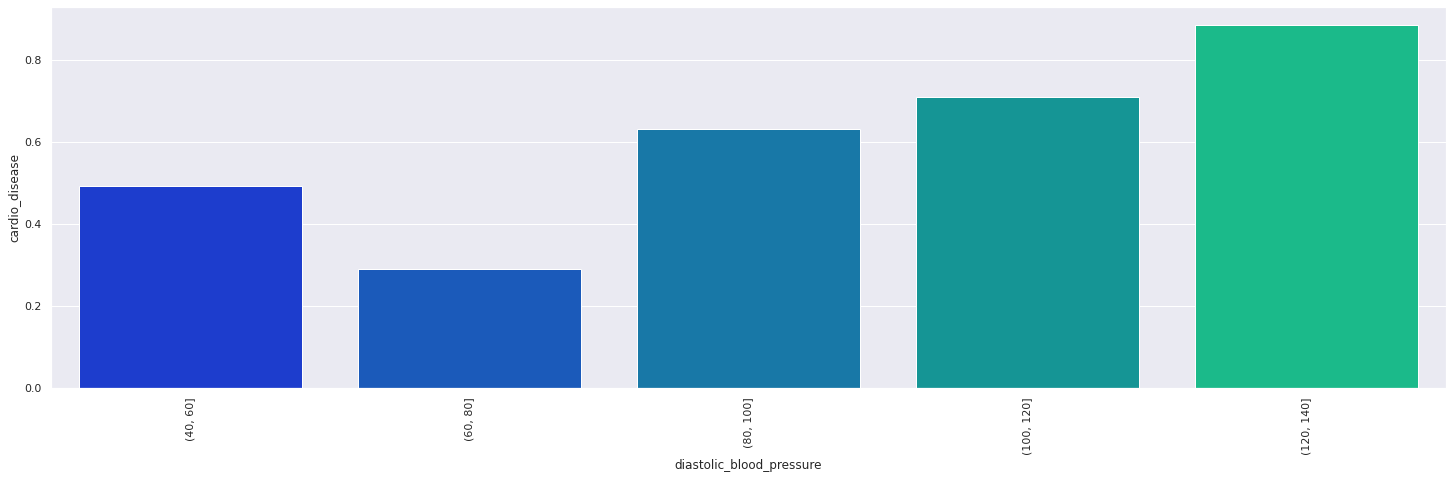

In [58]:
sns.set(rc={'figure.figsize':(25,7)})
aux1 = df4[['diastolic_blood_pressure', 'cardio_disease']].groupby('diastolic_blood_pressure').mean().reset_index()

bins = list(np.arange(40, 150, 20))
aux1['diastolic_blood_pressure'] = pd.cut (aux1['diastolic_blood_pressure'], bins = bins)
aux2 = aux1[['diastolic_blood_pressure', 'cardio_disease']].groupby('diastolic_blood_pressure').mean().reset_index()
sns.barplot (x = 'diastolic_blood_pressure', y = 'cardio_disease', data = aux2, palette = 'winter')
plt.xticks(rotation = 90);

**H7: People with higher cholesterol should have more cardio disease.**
- **True.** People with higher cholesterol have more cardio disease. 

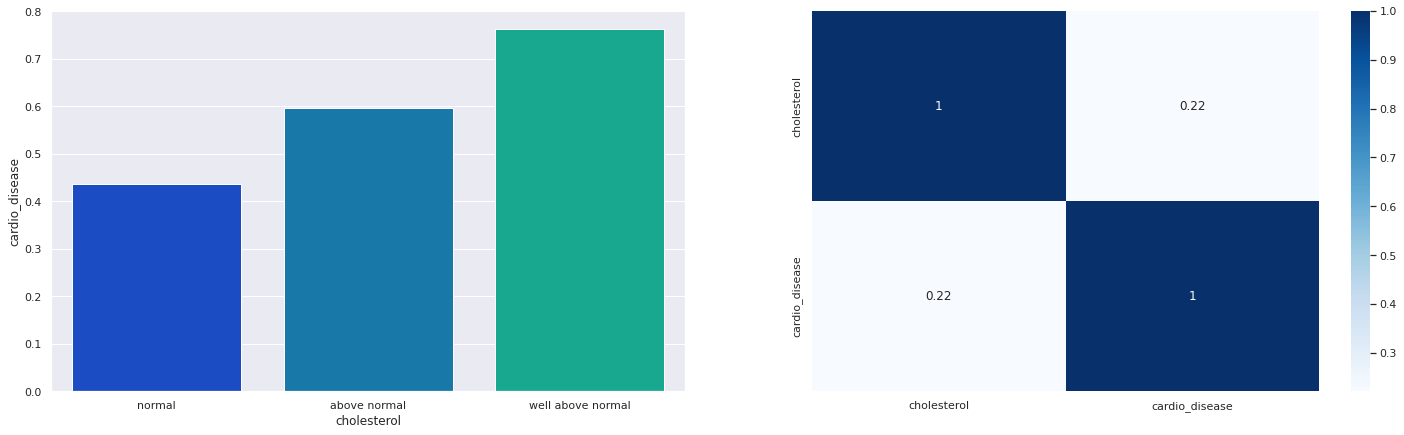

In [59]:
sns.set(rc={'figure.figsize':(25,7)})
aux1 = df4[['cholesterol', 'cardio_disease']].groupby('cholesterol').mean().reset_index()
plt.subplot (1,2,1)
sns.barplot (x = 'cholesterol', y = 'cardio_disease', data = aux1, palette = 'winter', order = ['normal', 'above normal', 'well above normal']);

aux2 = df4[['cholesterol', 'cardio_disease']]
aux2['cholesterol'] = aux2['cholesterol'].apply( lambda x: 1 if x == 'normal' else 2 if x == 'above normal' else 3)
plt.subplot (1,2,2)
sns.heatmap(aux2.corr(method= 'pearson'), annot = True, cmap="Blues");

In [60]:
cardio_table(df4,'cholesterol')

,cholesterol,cardio_disease_1,Total_Patients,Cardiac Patients Ratio (%),Patients Percentage
0,above normal,5533,9280,59.62,13.54
1,normal,22404,51421,43.57,75.00
2,well above normal,5997,7861,76.29,11.47


**H8:Men should have more cardio disease then women.**
- **False** Men suffer a little less heart disease than women.

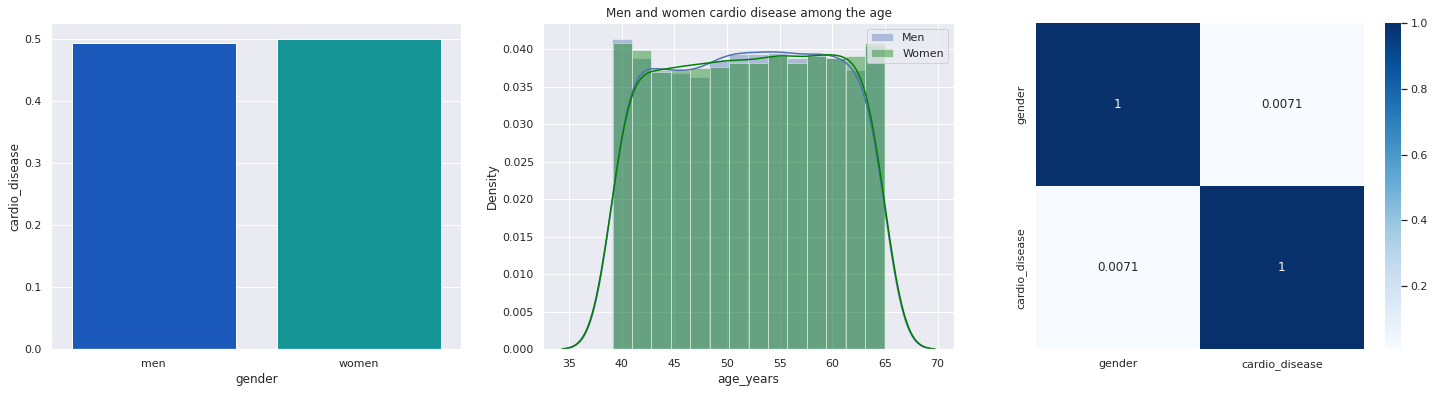

In [61]:

plt.subplots(figsize=(25,6))

plt.subplot (1,3,1)
aux1 = df4[['gender', 'cardio_disease']].groupby('gender').mean().reset_index()
sns.barplot (x = 'gender', y = 'cardio_disease', data = aux1, palette = 'winter');

plt.subplot (1,3,2)
aux2 = df4[df4['gender'] == 'men'][['age_years','cardio_disease']].groupby('age_years').mean().reset_index()
aux3 = df4[df4['gender'] == 'women'][['age_years','cardio_disease']].groupby('age_years').mean().reset_index()

sns.distplot(aux2['age_years'], label='Men');
sns.distplot(aux3['age_years'], color='green', label='Women');
plt.title('Men and women cardio disease among the age');
plt.legend();

aux4 = df4[['gender', 'cardio_disease']]
aux4['gender'] = aux4['gender'].apply( lambda x: 1 if x == 'women' else 0)
plt.subplot (1,3,3)
sns.heatmap(aux4.corr(method= 'pearson'), annot = True, cmap="Blues");

In [62]:
cardio_table(df4,'gender')

,gender,cardio_disease_1,Total_Patients,Cardiac Patients Ratio (%),Patients Percentage
0,men,21972,44629,49.23,65.09
1,women,11962,23933,49.98,34.91


**H9: Obese people should have more cardio disease.**
- **True.** Obese people Have More cardio disease.

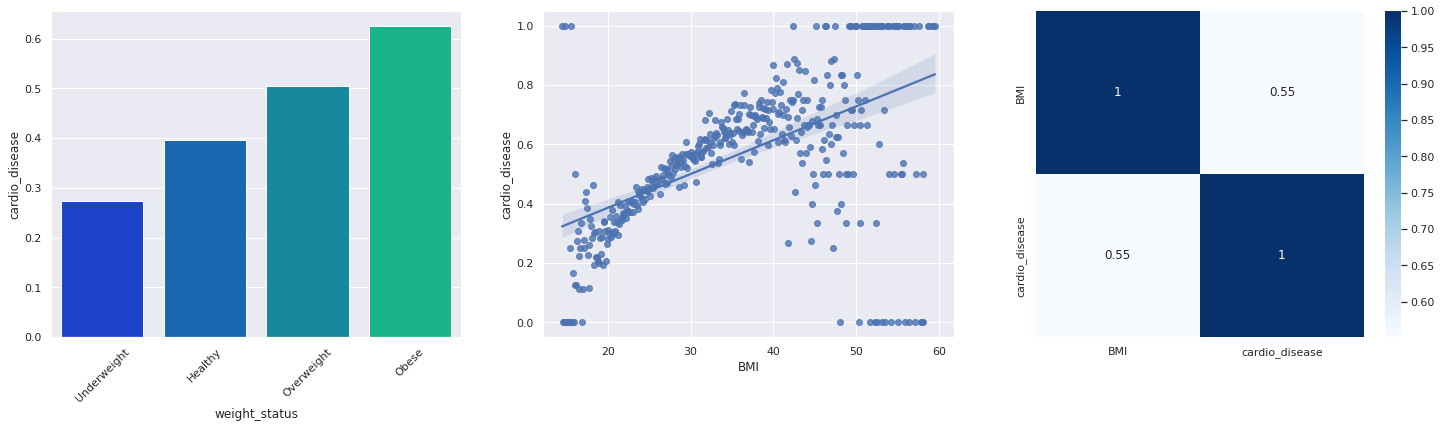

In [64]:
plt.subplots(figsize=(25,6))

plt.subplot (1,3,1)
aux1 = df4[['weight_status', 'cardio_disease']].groupby('weight_status').mean().reset_index()
sns.barplot (x = 'weight_status', y = 'cardio_disease', data = aux1, palette = 'winter', order = ['Underweight', 'Healthy', 'Overweight', 'Obese']);
plt.xticks(rotation = 45);

plt.subplot (1,3,2)
aux2 = df4[['BMI', 'cardio_disease']].groupby('BMI').mean().reset_index()
sns.regplot(x = 'BMI', y = 'cardio_disease', data = aux2);

plt.subplot (1,3,3)
sns.heatmap(aux2.corr(method= 'pearson'), annot = True, cmap="Blues");

In [65]:
cardio_table(df4,'weight_status')

,weight_status,cardio_disease_1,Total_Patients,Cardiac Patients Ratio (%),Patients Percentage
0,Healthy,9860,24863,39.66,36.26
1,Obese,11269,18047,62.44,26.32
2,Overweight,12655,25103,50.41,36.61
3,Underweight,150,549,27.32,0.80


**H10: Height should not interfere with the likelihood of cardio disease.**
- **True.** Height dont interfere with with the likelihood of cardio disease.

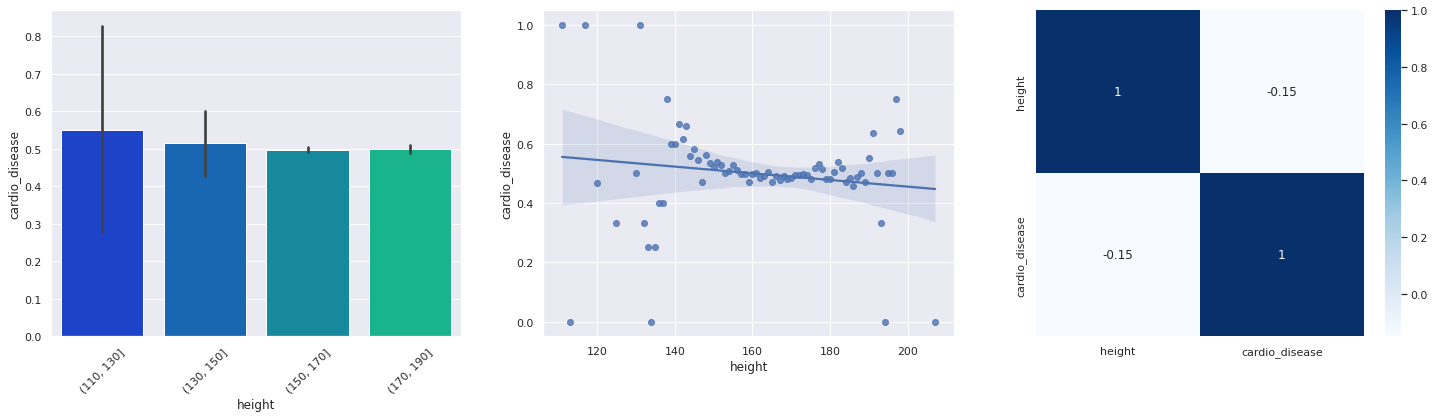

In [66]:
plt.subplots(figsize=(25,6))

plt.subplot (1,3,1)
aux1 = df4[['height', 'cardio_disease']].groupby('height').mean().reset_index()
bins = list(np.arange(110, 210, 20))
aux1['height'] = pd.cut (aux1['height'], bins = bins)
aux2 = aux1[['height', 'cardio_disease']].groupby('height').mean().reset_index()
sns.barplot (x = 'height', y = 'cardio_disease', data = aux1, palette = 'winter');
plt.xticks(rotation = 45);

plt.subplot (1,3,2)
aux3 = df4[['height', 'cardio_disease']].groupby('height').mean().reset_index()
sns.regplot(x = 'height', y = 'cardio_disease', data = aux3);

plt.subplot (1,3,3)
sns.heatmap(aux3.corr(method= 'pearson'), annot = True, cmap="Blues");

**H11: Ekderly people should have more cardio disease.**
- **True.** Elderly people have more cario disease.

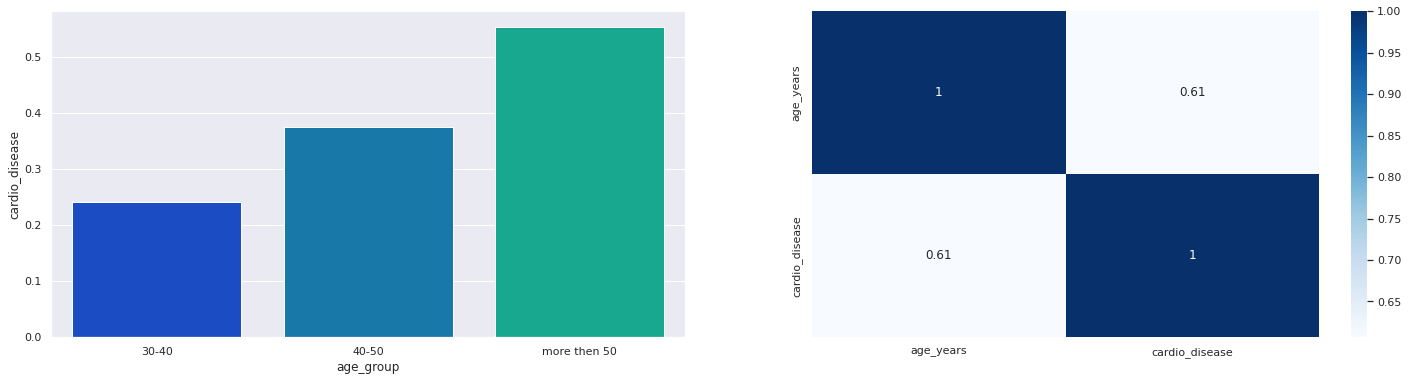

In [67]:
plt.subplots(figsize=(25,6))

plt.subplot (1,2,1)
aux1 = df4[['age_group', 'cardio_disease']].groupby('age_group').mean().reset_index()
sns.barplot (x = 'age_group', y = 'cardio_disease', data = aux1, palette = 'winter');

plt.subplot (1,2,2)
aux2 = df4[['age_years', 'cardio_disease']].groupby('age_years').mean().reset_index()
sns.heatmap(aux2.corr(method= 'pearson'), annot = True, cmap="Blues");

In [68]:
cardio_table(df4,'age_group')

,age_group,cardio_disease_1,Total_Patients,Cardiac Patients Ratio (%),Patients Percentage
0,30-40,425,1766,24.07,2.58
1,40-50,7221,19288,37.44,28.13
2,more then 50,26288,47508,55.33,69.29


**H12: People who practice physical activities should have less cardio disease.**
- **True.** People who practice physical activitiy regulary have less cardio disease** 

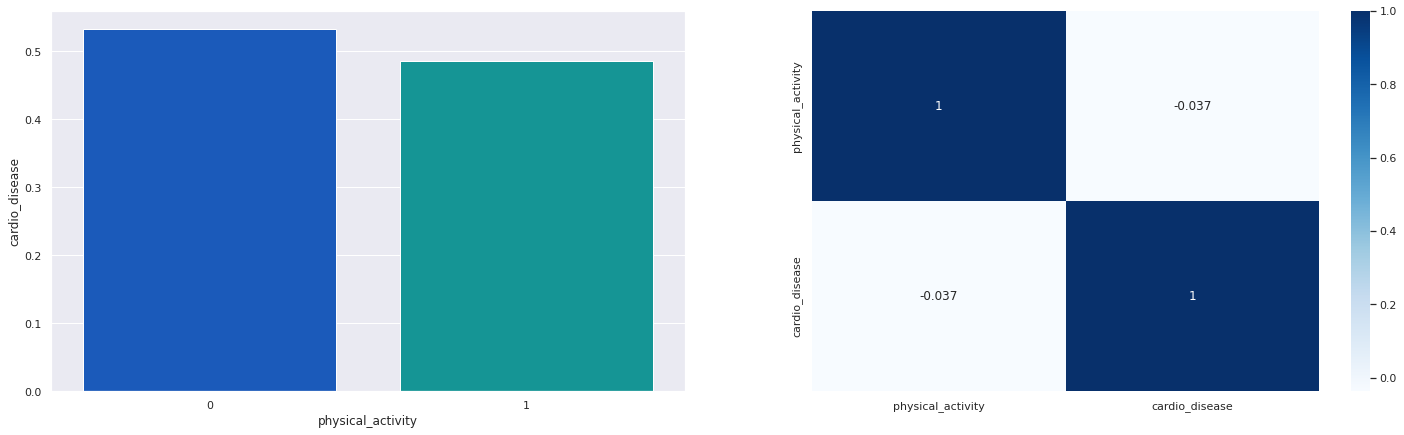

In [69]:
plt.subplots(figsize=(25,7))

plt.subplot (1,2,1)
aux1 = df4[['physical_activity', 'cardio_disease']].groupby('physical_activity').mean().reset_index()
sns.barplot (x = 'physical_activity', y = 'cardio_disease', data = aux1, palette = 'winter');

plt.subplot (1,2,2)
aux2 = df4[['physical_activity', 'cardio_disease']]
sns.heatmap(aux2.corr(method= 'pearson'), annot = True, cmap="Blues");

In [70]:
cardio_table(df4,'physical_activity')


,physical_activity,cardio_disease_1,Total_Patients,Cardiac Patients Ratio (%),Patients Percentage
0,0,7185,13489,53.27,19.67
1,1,26749,55073,48.57,80.33


**H13: People who smoke should have more cardio disease.**
- **False.** People who smoke have less cardio disease.

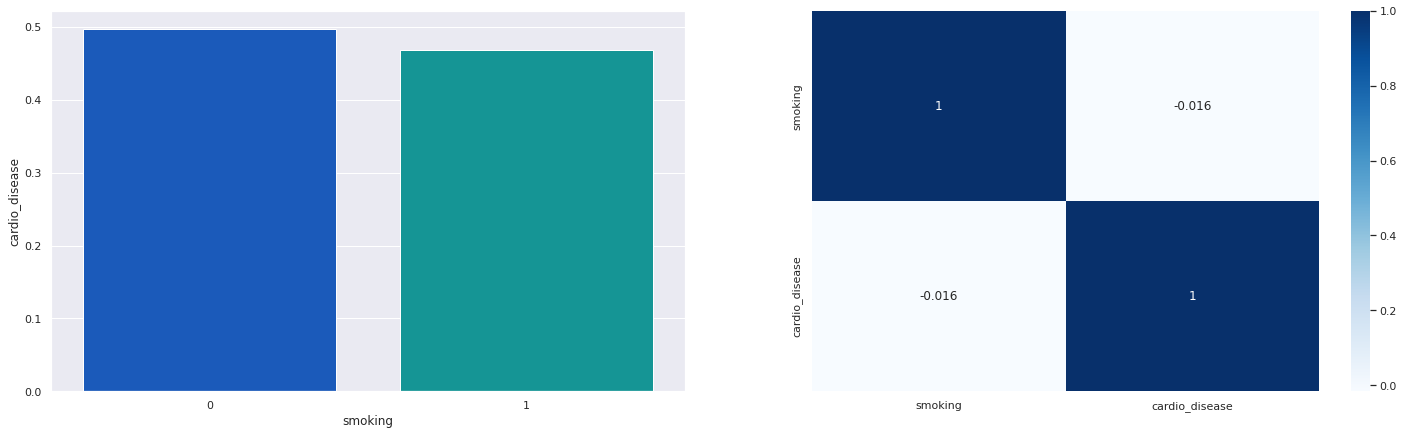

In [71]:
plt.subplot (1,2,1)
aux1 = df4[['smoking', 'cardio_disease']].groupby('smoking').mean().reset_index()
sns.barplot (x = 'smoking', y = 'cardio_disease', data = aux1, palette = 'winter');

plt.subplot (1,2,2)
aux2 = df4[['smoking', 'cardio_disease']]
sns.heatmap(aux2.corr(method= 'pearson'), annot = True, cmap="Blues");

In [72]:
cardio_table(df4,'smoking')

,smoking,cardio_disease_1,Total_Patients,Cardiac Patients Ratio (%),Patients Percentage
0,0,31103,62521,49.75,91.19
1,1,2831,6041,46.86,8.81


### 4.2.1 Hypotheses resume

In [73]:
# display columns complete description
pd.set_option('display.max_colwidth', None)

# Hypothesis Summary dataframe
summary = pd.DataFrame({'Hypothesis':['People with hipertension should have more cardio disease.',
                                      'People with diabetes should have more cardio disease.',
                                      'People with systolic blood pressure higher then 140 should have more cardio disease.',
                                      'People with systolic blood pressure lower then 90 should have more cardio disease.',
                                      'People with diastolic blood pressure higher then 90 should have more cardio disease.',
                                      'People with diastolic blood pressure lower then 60 should have more cardio disease.',
                                      'People with higher cholesterol should have more cardio disease.',
                                      'Men should have more cardio disease then women.',
                                      'Obese people should have more cardio disease.',
                                      'Height should not interfere with the likelihood of cardio disease.',
                                      'Elderly people should have more cardio disease.',
                                      'People who practice physical activities should have less cardio disease.',
                                      'People who smoke should have more cardio disease.',
                                      ],
                        'True / False':['True', 'True', 'True', 'False', 'True', 'True', 'True', 'False', 'True',
                                        'True', 'True','True', 'False'], 
                        'Relevance':['High', 'High', 'High', 'Medium', 'Medium', 'Medium', 'High', 'Low', 'Medium', 'Low',
                                     'High','High','High']}, 
                        index=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
summary

,Hypothesis,True / False,Relevance
1,People with hipertension should have more cardio disease.,True,High
2,People with diabetes should have more cardio disease.,True,High
3,People with systolic blood pressure higher then 140 should have more cardio disease.,True,High
4,People with systolic blood pressure lower then 90 should have more cardio disease.,False,Medium
5,People with diastolic blood pressure higher then 90 should have more cardio disease.,True,Medium
6,People with diastolic blood pressure lower then 60 should have more cardio disease.,True,Medium
7,People with higher cholesterol should have more cardio disease.,True,High
8,Men should have more cardio disease then women.,False,Low
9,Obese people should have more cardio disease.,True,Medium
10,Height should not interfere with the likelihood of cardio disease.,True,Low


## 4.3 Multi Variate Analysis

### 4.3.1 Numerial Attributes

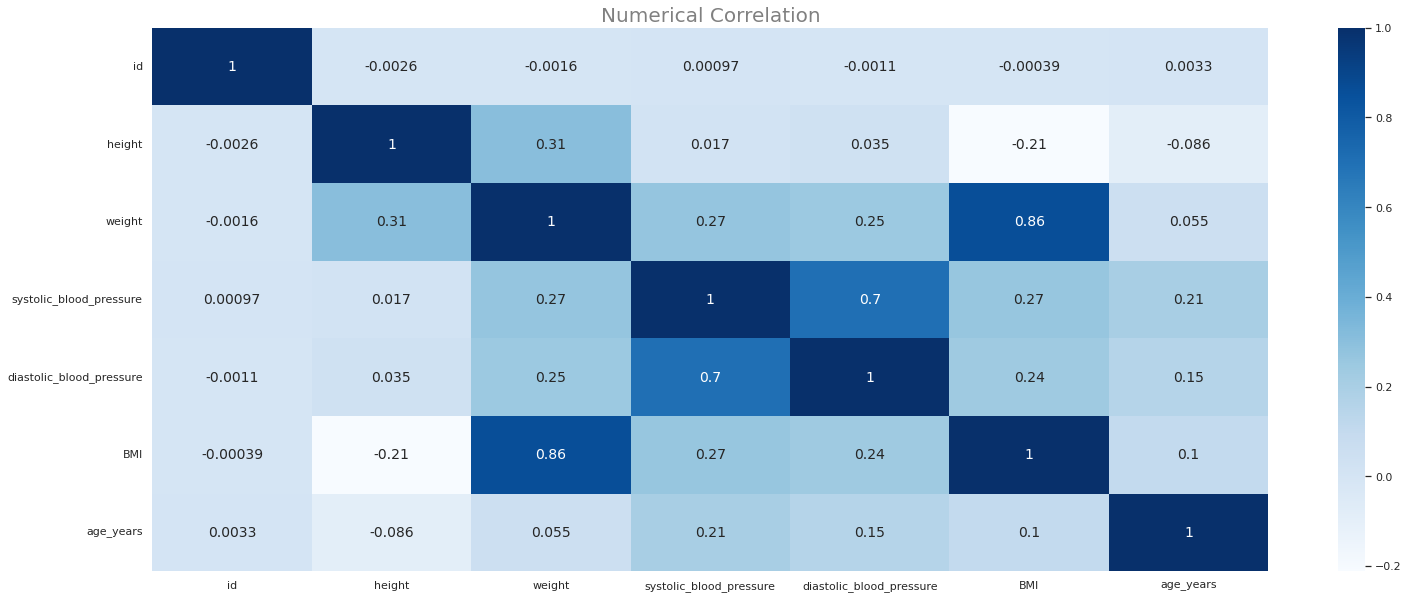

In [74]:
fig = plt.figure(figsize = (25,10))
correlation = num_attributes.corr(method = 'pearson')
sns.heatmap(correlation, annot = True, annot_kws={"fontsize":14}, cmap="Blues");
plt.title("Numerical Correlation", size=20, color='gray');

### 4.3.2 Binary x Numerical Attributes

In [75]:
### Correlation among Numerical and Binary Variables

num_attributes.columns

Index(['id', 'height', 'weight', 'systolic_blood_pressure',
       'diastolic_blood_pressure', 'BMI', 'age_years'],
      dtype='object')

In [76]:
bin_attributes.columns

Index(['smoking', 'alcohol', 'physical_activity', 'cardio_disease'], dtype='object')

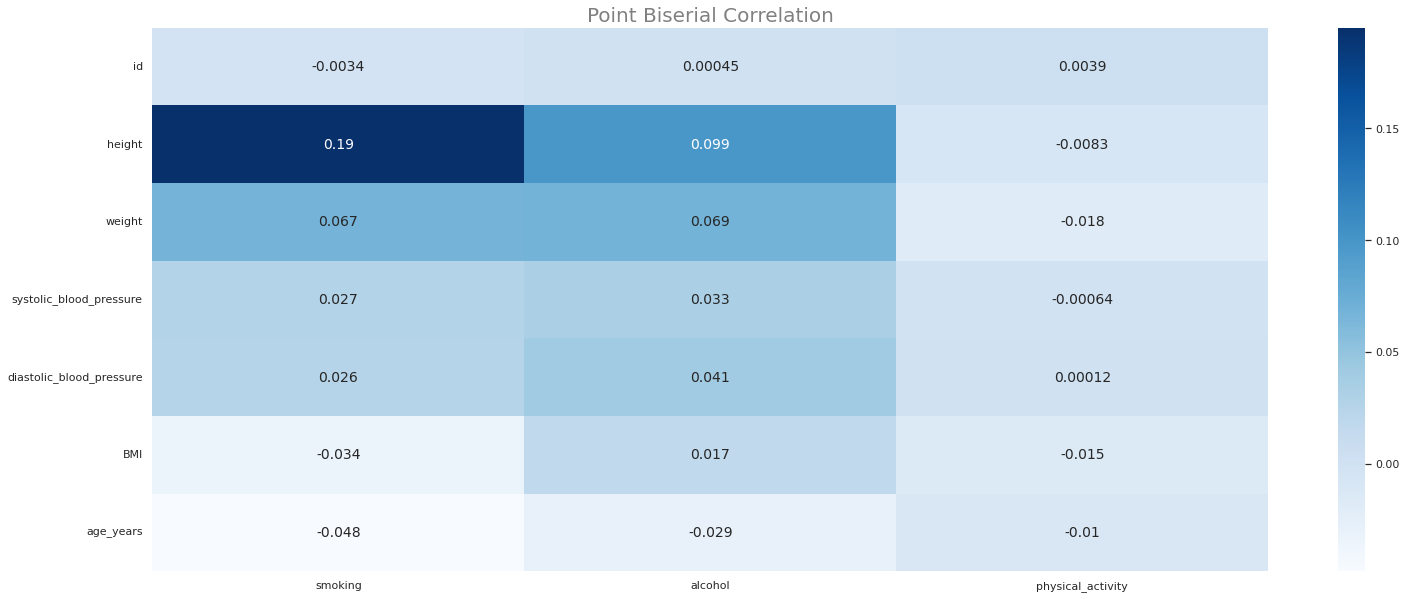

In [77]:
## Only numerical and binary data

# Calculate point bisserial correlation
x1 = pointbiserialr(bin_attributes['smoking'], num_attributes['id'])[0]
x2 = pointbiserialr(bin_attributes['smoking'], num_attributes['height'])[0]
x3 = pointbiserialr(bin_attributes['smoking'], num_attributes['weight'])[0]
x4 = pointbiserialr(bin_attributes['smoking'], num_attributes['systolic_blood_pressure'])[0]
x5 = pointbiserialr(bin_attributes['smoking'], num_attributes['diastolic_blood_pressure'])[0]
x6 = pointbiserialr(bin_attributes['smoking'], num_attributes['BMI'])[0]
x7 = pointbiserialr(bin_attributes['smoking'], num_attributes['age_years'])[0]

x8 = pointbiserialr(bin_attributes['alcohol'], num_attributes['id'])[0]
x9 = pointbiserialr(bin_attributes['alcohol'], num_attributes['height'])[0]
x10 = pointbiserialr(bin_attributes['alcohol'], num_attributes['weight'])[0]
x11 = pointbiserialr(bin_attributes['alcohol'], num_attributes['systolic_blood_pressure'])[0]
x12 = pointbiserialr(bin_attributes['alcohol'], num_attributes['diastolic_blood_pressure'])[0]
x13 = pointbiserialr(bin_attributes['alcohol'], num_attributes['BMI'])[0]
x14 = pointbiserialr(bin_attributes['alcohol'], num_attributes['age_years'])[0]

x15 = pointbiserialr(bin_attributes['physical_activity'], num_attributes['id'])[0]
x16 = pointbiserialr(bin_attributes['physical_activity'], num_attributes['height'])[0]
x17 = pointbiserialr(bin_attributes['physical_activity'], num_attributes['weight'])[0]
x18 = pointbiserialr(bin_attributes['physical_activity'], num_attributes['systolic_blood_pressure'])[0]
x19 = pointbiserialr(bin_attributes['physical_activity'], num_attributes['diastolic_blood_pressure'])[0]
x20 = pointbiserialr(bin_attributes['physical_activity'], num_attributes['BMI'])[0]
x21 = pointbiserialr(bin_attributes['physical_activity'], num_attributes['age_years'])[0]

# Final dataset
d = pd.DataFrame({'smoking':[x1, x2, x3, x4, x5, x6, x7],
                    'alcohol':[x8, x9, x10, x11, x12, x13, x14],
                    'physical_activity':[x15, x16, x17, x18, x19, x20, x21]})

# Sets the index equal to columns
d = d.set_index(num_attributes.columns)

fig = plt.figure(figsize = (25,10))
sns.heatmap(d, annot = True, annot_kws={"fontsize":14}, cmap="Blues");
plt.title("Point Biserial Correlation", size=20, color='gray');

### 4.3.3 Categorical Attributes

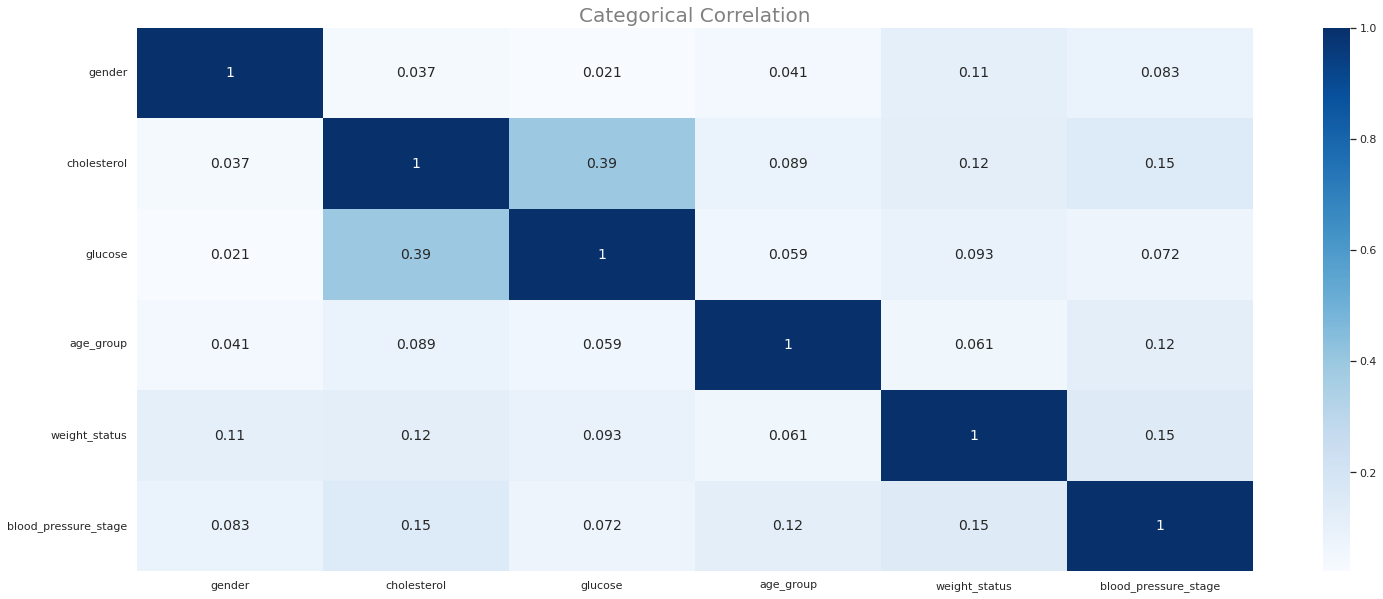

In [78]:
# Only categorical data
a = df4.select_dtypes( include = 'object')

# Calculate cramer v
a1 = cramer_v( a['gender'], a['gender'] )
a2 = cramer_v( a['gender'], a['cholesterol'] )
a3 = cramer_v( a['gender'], a['glucose'] )
a4 = cramer_v( a['gender'], a['age_group'] )
a5 = cramer_v( a['gender'], a['weight_status'] )
a6 = cramer_v( a['gender'], a['blood_pressure_stage'] )

a7 = cramer_v( a['cholesterol'], a['gender'] )
a8 = cramer_v( a['cholesterol'], a['cholesterol'] )
a9 = cramer_v( a['cholesterol'], a['glucose'] )
a10 = cramer_v( a['cholesterol'], a['age_group'] )
a11 = cramer_v( a['cholesterol'], a['weight_status'] )
a12 = cramer_v( a['cholesterol'], a['blood_pressure_stage'] )

a13 = cramer_v( a['glucose'], a['gender'] )
a14 = cramer_v( a['glucose'], a['cholesterol'] )
a15 = cramer_v( a['glucose'], a['glucose'] )
a16 = cramer_v( a['glucose'], a['age_group'] )
a17 = cramer_v( a['glucose'], a['weight_status'] )
a18 = cramer_v( a['glucose'], a['blood_pressure_stage'] )

a19 = cramer_v( a['age_group'],  a['gender'] )
a20 = cramer_v( a['age_group'], a['cholesterol'] )
a21 = cramer_v( a['age_group'], a['glucose'] )
a22 = cramer_v( a['age_group'], a['age_group'] )
a23 = cramer_v( a['age_group'],  a['weight_status'] )
a24 = cramer_v( a['age_group'],  a['blood_pressure_stage'] )

a25 = cramer_v( a['weight_status'], a['gender'] )
a26 = cramer_v( a['weight_status'], a['cholesterol'] )
a27 = cramer_v( a['weight_status'], a['glucose'] )
a28 = cramer_v( a['weight_status'], a['age_group'] )
a29 = cramer_v( a['weight_status'],  a['weight_status'] )
a30 = cramer_v( a['weight_status'], a['blood_pressure_stage'] )

a31 = cramer_v( a['blood_pressure_stage'], a['gender'] )
a32 = cramer_v( a['blood_pressure_stage'], a['cholesterol'] )
a33 = cramer_v( a['blood_pressure_stage'], a['glucose'] )
a34 = cramer_v( a['blood_pressure_stage'], a['age_group'] )
a35 = cramer_v( a['blood_pressure_stage'], a['weight_status'] )
a36 = cramer_v( a['blood_pressure_stage'], a['blood_pressure_stage'] )

# Final dataset
d = pd.DataFrame( {'gender': [a1, a2, a3, a4, a5, a6],
                   'cholesterol': [a7, a8, a9, a10, a11, a12],
                   'glucose': [a13, a14, a15, a16, a17, a18],
                   'age_group': [a19, a20, a21, a22, a23, a24],
                   'weight_status': [a25, a26, a27, a28, a29, a30],
                   'blood_pressure_stage': [a31, a32, a33, a34, a35, a36],})

d = d.set_index(d.columns)

fig = plt.figure(figsize = (25,10))
sns.heatmap(d, annot = True, annot_kws={"fontsize":14}, cmap="Blues");
plt.title("Categorical Correlation", size=20, color='gray');

# 5.0. Data Preparation

In [79]:
df5 = df4.copy()

In [80]:
df5.columns

Index(['id', 'gender', 'height', 'weight', 'systolic_blood_pressure',
       'diastolic_blood_pressure', 'cholesterol', 'glucose', 'smoking',
       'alcohol', 'physical_activity', 'cardio_disease', 'age_years',
       'age_group', 'BMI', 'weight_status', 'blood_pressure_stage'],
      dtype='object')

## 5.1 Rescaling Features

In [82]:
mms = MinMaxScaler()

# numerical variable different from binary
df5[["height", "weight", "systolic_blood_pressure", "diastolic_blood_pressure", "age_years", "BMI"]] = mms.fit_transform( df5[["height", "weight", "systolic_blood_pressure", "diastolic_blood_pressure", "age_years", "BMI"]])
pickle.dump( mms, open('../numerical_scaler.pkl', 'wb'))

In [83]:
df5.head()

,id,gender,height,weight,systolic_blood_pressure,diastolic_blood_pressure,cholesterol,glucose,smoking,alcohol,physical_activity,cardio_disease,age_years,age_group,BMI,weight_status,blood_pressure_stage
0,0,women,0.593750,0.132075,0.333333,0.363636,normal,normal,0,0,1,0,0.436195,more then 50,0.166667,Healthy,high (stage 1)
1,1,men,0.468750,0.276730,0.533333,0.454545,well above normal,normal,0,0,1,1,0.630704,more then 50,0.453333,Obese,high (stage 2)
2,2,men,0.562500,0.144654,0.466667,0.272727,well above normal,normal,0,0,0,1,0.485305,more then 50,0.200000,Healthy,high (stage 1)
3,3,women,0.604167,0.257862,0.600000,0.545455,normal,normal,0,0,1,1,0.354602,40-50,0.315556,Overweight,high (stage 2)
4,4,men,0.468750,0.094340,0.266667,0.181818,normal,normal,0,0,0,0,0.338747,40-50,0.188889,Healthy,low


## 5.2 Features Transformation

### 5.2.1 Encoding

In [84]:
# ONEHOT ENCODING:
# gender
onehot = ["gender", "smoking", "alcohol", "physical_activity", "cardio_disease"]
df5 = pd.get_dummies(df5, columns = onehot, drop_first=True)

# ORDINAL ENCODING:
# cholesterol
df5["cholesterol"] = df5["cholesterol"].map({"normal": 0, "above normal": 1, "well above normal": 2})
# glucose
df5["glucose"] = df5["glucose"].map({"normal": 0, "above normal": 1, "well above normal": 2})
# age_group
df5["age_group"] = df5["age_group"].map({"less then 30":0 ,"30-40": 1, "40-50": 2, "more then 50": 3})
# weight_status
df5["weight_status"] = df5["weight_status"].map({"Underweight": 0, "Healthy": 1,  "Overweight": 2, "Obese": 3})
# blood_pressure_stage
df5["blood_pressure_stage"] = df5["blood_pressure_stage"].map({"low": 0, "normal": 1, "elevated": 2, "high (stage 1)": 3,  "high (stage 2)": 4, "hypertensive crisis": 5})

# 6.0. Feature Selection

# 7.0. Hyperparameter Fine-tuning

# 8.0. Model Training

# 9.0. Cluster Analysis

# 10.0. Deploy to Production